<a href="https://colab.research.google.com/github/soutrik71/School_of_AI_ERA/blob/main/session6/Session6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Mount Google Drive
from google.colab import drive # import drive from google colab
ROOT = "/content/gdrive"     # default location for the drive
print(ROOT)                 # print content of ROOT (Optional)
drive.mount(ROOT,force_remount=True)           # we mount the google drive at /content/drive

/content/gdrive
Mounted at /content/gdrive


In [2]:
%cd /content/gdrive/MyDrive/School_of_AI_ERA

/content/gdrive/MyDrive/School_of_AI_ERA


In [3]:
# !cp "/content/gdrive/MyDrive/Colab Notebooks/Session6.ipynb" /session6

## Imports

In [4]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [5]:
!pip install torchview
!pip install torcheval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 4.2 MB/s eta 0:00:00


In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import torchvision.datasets as datasets
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
from torchview import draw_graph
from pathlib import Path
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import random
from torcheval.metrics import MulticlassAccuracy,BinaryAccuracy
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ReduceLROnPlateau, StepLR, OneCycleLR, ExponentialLR

In [7]:
print(f"PyTorch version: {torch.__version__}\ntorchvision version: {torchvision.__version__}")

PyTorch version: 2.1.0+cu121
torchvision version: 0.16.0+cu121


In [8]:
def set_seed(seed: int = 42) -> None:
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ["PYTHONHASHSEED"] = str(seed)
    print(f"Random seed set as {seed}")

In [9]:
# decorator function to record time exp
from functools import wraps
import time

def timeit(func):
    @wraps(func)
    def timeit_wrapper(*args, **kwargs):
        start_time = time.perf_counter()
        result = func(*args, **kwargs)
        end_time = time.perf_counter()
        total_time = end_time - start_time
        print(f'Function Took {total_time:.4f} seconds')
        return result
    return timeit_wrapper

### Basic Hyper params and Helper methods

In [10]:
# Set manual seed since nn.Parameter are randomly initialzied
set_seed(42)
# Set device cuda for GPU if it's available otherwise run on the CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
batch_size = 128
epochs = 20
lr = 1e-3

Random seed set as 42
cuda


In [69]:
def plot_loss_accuracy(train_loss, val_loss, train_acc, val_acc, labels, colors,
                       loss_legend_loc='upper center', acc_legend_loc='upper left', legend_font=10,
                       fig_size=(16, 8), sub_plot1=(1, 2, 1), sub_plot2=(1, 2, 2)):

    """Plot traning and testing losses and metrics"""

    plt.rcParams["figure.figsize"] = fig_size
    plt.figure


    plt.subplot(sub_plot1[0], sub_plot1[1], sub_plot1[2])

    for i in range(len(train_loss)):
        x_train = range(len(train_loss[i]))
        x_val = range(len(val_loss[i]))

        min_train_loss = np.array(train_loss[i]).min()

        min_val_loss = np.array(val_loss[i]).min()

        plt.plot(x_train, train_loss[i], linestyle='-', color='tab:{}'.format(colors[i]),
                 label="TRAIN ({0:.4}): {1}".format(min_train_loss, labels[i]))
        plt.plot(x_val, val_loss[i], linestyle='--' , color='tab:{}'.format(colors[i]),
                 label="VALID ({0:.4}): {1}".format(min_val_loss, labels[i]))

    plt.xlabel('epoch no.')
    plt.ylabel('loss')
    plt.legend(loc=loss_legend_loc, prop={'size': legend_font})
    plt.title('Training and Validation Loss')

    plt.subplot(sub_plot2[0], sub_plot2[1], sub_plot2[2])

    for i in range(len(train_acc)):
        x_train = range(len(train_acc[i]))
        x_val = range(len(val_acc[i]))

        max_train_acc = np.array(train_acc[i]).max()

        max_val_acc = np.array(val_acc[i]).max()

        plt.plot(x_train, train_acc[i], linestyle='-', color='tab:{}'.format(colors[i]),
                 label="TRAIN ({0:.4}): {1}".format(max_train_acc, labels[i]))
        plt.plot(x_val, val_acc[i], linestyle='--' , color='tab:{}'.format(colors[i]),
                 label="VALID ({0:.4}): {1}".format(max_val_acc, labels[i]))

    plt.xlabel('epoch no.')
    plt.ylabel('accuracy')
    plt.legend(loc=acc_legend_loc, prop={'size': legend_font})
    plt.title('Training and Validation Accuracy')

    plt.show()


In [12]:

def regularization(model , reg_type, reg_coeff):
  """Model regularization"""
  loss_params = []
  for parameter in model.parameters():
    loss_params.append(parameter.view(-1))

  if reg_type == "l1":
    reg_factor = reg_coeff * model.l1_loss(torch.cat(loss_params))
    return reg_factor
  elif reg_type == "l2":
    reg_factor = reg_coeff * model.l2_loss(torch.cat(loss_params))
    return reg_factor
  elif reg_type is None:
    return 0

In [13]:
class EarlyStopping:

    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=3, verbose=True, delta=1e-5, trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement.
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = "checkpoint.pt"
        self.trace_func = trace_func
    def __call__(self, val_loss, model, epoch):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

## Data Preprocessing

### Basic Transformation

In [14]:
# different kinds of data augmentation in training data
train_transform  = transforms.Compose([
    transforms.RandomRotation((-15., 15.), fill=0),
    transforms.RandomApply([transforms.CenterCrop(22), ], p=0.1),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.Resize((28,28)),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
    ])

# basic preprocessing of actual test data
test_transform = transforms.Compose([
    transforms.Resize((28,28)),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
    ])

In [15]:
# reading the mnist data with application of transformers
train_data = datasets.MNIST('../data', train=True, download=True, transform=train_transform)
test_data = datasets.MNIST('../data', train=False, download=True, transform=train_transform)

In [16]:
print(f"Number of training examples: {len(train_data)}")
print(f"Number of test examples: {len(test_data)}")
print(f"Number of classes: {len(train_data.classes)}")
print(f"Size of each training image is {train_data.data[0].shape} and that of each testing image is {test_data.data[0].shape}")

Number of training examples: 60000
Number of test examples: 10000
Number of classes: 10
Size of each training image is torch.Size([28, 28]) and that of each testing image is torch.Size([28, 28])


In [17]:
class_names = train_data.classes
print(class_names)

['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']


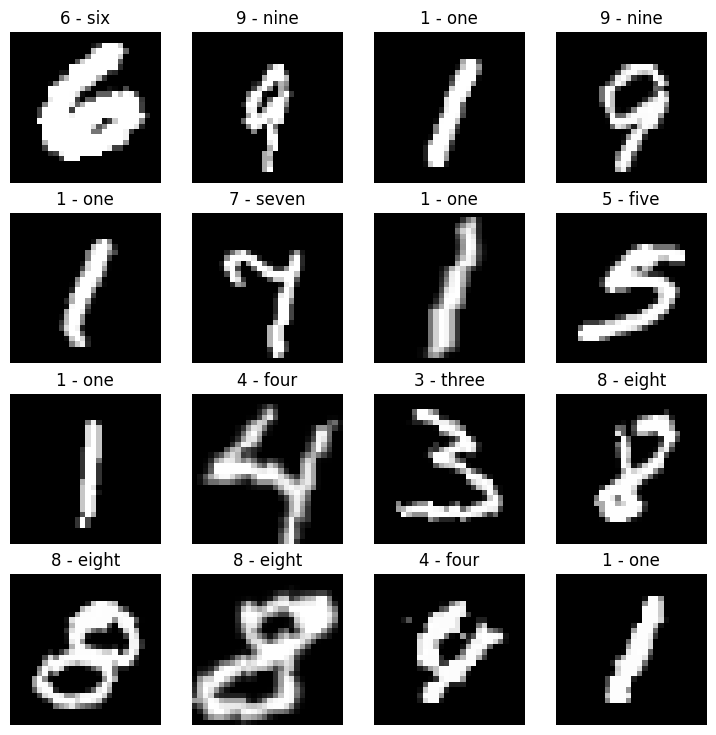

In [18]:
# Plot more images
torch.manual_seed(42)
fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4
for i in range(1, rows * cols + 1):
    random_idx = torch.randint(0, len(train_data), size=[1]).item()
    img, label = train_data[random_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze(), cmap="gray")
    plt.title(class_names[label])
    plt.axis(False);

In [19]:
# Loading the train and test loader
kwargs = {'batch_size': batch_size, 'shuffle': True, 'num_workers': 1, 'pin_memory': True}
test_loader = torch.utils.data.DataLoader(test_data, **kwargs)
train_loader = torch.utils.data.DataLoader(train_data, **kwargs)

In [20]:
for images, labels in train_loader:
    print(images.shape)
    print(labels.shape)
    break

torch.Size([128, 1, 28, 28])
torch.Size([128])


## Model Building

Below are a few Basic things that we plan to try :
1. Baseline model with only 2 layers of convolution block and one layer of 3 fc making sure total params are within 20k
2. Next we will try adding Batch norm and Dropout at right positions
3. Application of Gloabl Average Pooling layer on top of the Fc block
4. Next we will try using adaptive learning rate like exp lr and cyclic lr
5. Next we will try improving the model with  ReduceLROnPlateau
6. If required we will also try better initailization of weights

### Best Model as per Kaggle

https://www.kaggle.com/code/enwei26/mnist-digits-pytorch-cnn-99/notebook

In [67]:
class BestModel(nn.Module):
    def __init__(self):
        super(BestModel, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 32, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.25)
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.25)
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.25)
        )

        self.fc = nn.Sequential(
            nn.Linear(128, 10)
        )


    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)

        x = x.view(x.size(0), -1)
        x = self.fc(x)
        x = F.log_softmax(x, dim=1)
        return x

In [68]:
# New Model Instance
best_model = BestModel().to(device)
summary(best_model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
              ReLU-2           [-1, 32, 28, 28]               0
       BatchNorm2d-3           [-1, 32, 28, 28]              64
            Conv2d-4           [-1, 32, 28, 28]           9,248
              ReLU-5           [-1, 32, 28, 28]               0
       BatchNorm2d-6           [-1, 32, 28, 28]              64
            Conv2d-7           [-1, 32, 14, 14]           9,248
              ReLU-8           [-1, 32, 14, 14]               0
       BatchNorm2d-9           [-1, 32, 14, 14]              64
        MaxPool2d-10             [-1, 32, 7, 7]               0
          Dropout-11             [-1, 32, 7, 7]               0
           Conv2d-12             [-1, 64, 7, 7]          18,496
             ReLU-13             [-1, 64, 7, 7]               0
      BatchNorm2d-14             [-1, 6

### Baseline model

In [21]:
class MnistBaseline(nn.Module):
    """Feedfoward neural network with 2 Cnn blocks and 1 hidden layer"""
    def __init__(self, in_channels, hidden_units, out_channels):
        super(MnistBaseline, self).__init__()
        # Input starts with (28,28)
        # each conv block is like [conv->relu->conv->relu->maxpool]

        self.block1 = nn.Sequential(
            nn.Conv2d(in_channels = in_channels,
                      out_channels = hidden_units,
                      kernel_size=(3,3),
                      stride=1,
                     padding=0), #(26,26,HDUN)
            nn.ReLU(),
            nn.Conv2d(in_channels = hidden_units,
                      out_channels= hidden_units,
                      kernel_size=(3,3),
                      stride=1,
                      padding=0
            ), #(24,24,HDUN)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,2),
                         stride=(2,2)) #(12,12,HDUN)
        )

        self.block2 = nn.Sequential(
            nn.Conv2d(in_channels = hidden_units,
                      out_channels = hidden_units,
                      kernel_size=(3,3),
                      stride=1,
                      padding=0), #(10,10,HDUN)
            nn.ReLU(),
            nn.Conv2d(in_channels = hidden_units,
                      out_channels =hidden_units,
                      kernel_size=(3,3),
                      stride=1,
                      padding=0), #(8,8,HDUN)

            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,2),
                         stride=(2,2)) #(4,4,HDUN)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(4*4*hidden_units, out_channels*10),
            nn.ReLU(),
            nn.Linear(out_channels*10, out_channels*5),
            nn.ReLU(),
            nn.Linear(out_channels*5, out_channels)
        )

    def forward(self, x):
      """Forward propagation"""
      x = self.block1(x)
      x = self.block2(x)
      x = self.classifier(x)

      return x

In [22]:
# New Model Instance
baseline_model = MnistBaseline(in_channels=1,
                                           hidden_units=8,
                                           out_channels=10).to(device)
summary(baseline_model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              80
              ReLU-2            [-1, 8, 26, 26]               0
            Conv2d-3            [-1, 8, 24, 24]             584
              ReLU-4            [-1, 8, 24, 24]               0
         MaxPool2d-5            [-1, 8, 12, 12]               0
            Conv2d-6            [-1, 8, 10, 10]             584
              ReLU-7            [-1, 8, 10, 10]               0
            Conv2d-8              [-1, 8, 8, 8]             584
              ReLU-9              [-1, 8, 8, 8]               0
        MaxPool2d-10              [-1, 8, 4, 4]               0
          Flatten-11                  [-1, 128]               0
           Linear-12                  [-1, 100]          12,900
             ReLU-13                  [-1, 100]               0
           Linear-14                   

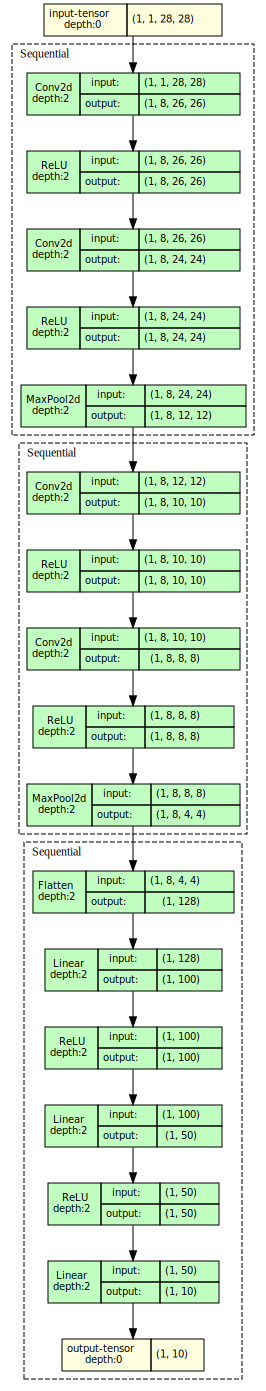

In [23]:
# graphical representation of the model architecture
model_graph = draw_graph(baseline_model, input_size=(1,1, 28, 28), expand_nested=True)
model_graph.resize_graph(scale=10)
model_graph.visual_graph

In [24]:
# updated training module---
@timeit
def train_module(model:torch.nn.Module,
                 device:torch.device,
                 train_dataloader:torch.utils.data.DataLoader ,
                 optimizer:torch.optim.Optimizer,
                 criterion:torch.nn.Module,
                 metric,
                 train_losses:list,
                 train_metrics:list):

  # setting model to train mode
  model.train()
  pbar = tqdm(train_dataloader)

  # batch metrics
  train_loss = 0
  train_metric = 0
  processed_batch = 0

  for idx, (data,label) in enumerate(pbar):
    # setting up device
    data = data.to(device)
    label = label.to(device)

    # forward pass output
    preds = model(data)

    # calc loss
    loss = criterion(preds, label)
    train_loss += loss.item()
    # print(f"training loss for batch {idx} is {loss}")

    # backpropagation
    optimizer.zero_grad() # flush out  existing grads
    loss.backward() # back prop of weights wrt loss
    optimizer.step() # optimizer step -> minima

    # metric calc
    preds = torch.argmax(preds,dim=1)
    # print(f"preds:: {preds}")
    metric.update(preds,label)
    train_metric += metric.compute().detach().item()

    #updating batch count
    processed_batch += 1

    pbar.set_description(f"Avg Train Loss: {train_loss/processed_batch} Avg Train Metric: {train_metric/processed_batch}")

  # It's typically called after the epoch completes
  metric.reset()
  # updating epoch metrics
  train_losses.append(train_loss/processed_batch)
  train_metrics.append(train_metric/processed_batch)

  return train_losses, train_metrics


In [25]:
# updated testing modules
@timeit
def test_module(model:torch.nn.Module,
                device:torch.device,
                test_dataloader:torch.utils.data.DataLoader,
                criterion:torch.nn.Module,
                metric,
                test_losses,
                test_metrics):
  # setting model to eval mode
  model.eval()
  pbar = tqdm(test_dataloader)

  # batch metrics
  test_loss = 0
  test_metric = 0
  processed_batch = 0

  with torch.inference_mode():
    for idx, (data,label) in enumerate(pbar):
      data , label = data.to(device), label.to(device)
      # predictions
      preds = model(data)
      # print(preds.shape)
      # print(label.shape)

      #loss calc
      loss = criterion(preds, label)
      test_loss += loss.item()

      # metric calc
      preds = torch.argmax(preds,dim=1)
      metric.update(preds,label)
      test_metric += metric.compute().detach().item()

      #updating batch count
      processed_batch += 1

      pbar.set_description(f"Avg Test Loss: {test_loss/processed_batch} Avg Test Metric: {test_metric/processed_batch}")

    # It's typically called after the epoch completes
    metric.reset()
    # updating epoch metrics
    test_losses.append(test_loss/processed_batch)
    test_metrics.append(test_metric/processed_batch)

  return test_losses, test_metrics

In [26]:
# driver setup----
# optmizer
optimizer = optim.Adam(baseline_model.parameters(), lr=lr)
# loss
criterion = nn.CrossEntropyLoss()
# metric
metric = MulticlassAccuracy(device = device, num_classes=10)
# Early stopping
early_stopping = EarlyStopping(patience=5, verbose=True)

In [27]:
train_losses = []
train_metrics = []
test_losses = []
test_metrics = []

for epoch in range(0,epochs):
  print(f'Epoch {epoch}')
  train_losses, train_metrics = train_module(baseline_model, device, train_loader, optimizer, criterion, metric, train_losses, train_metrics)
  test_losses , test_metrics = test_module(baseline_model, device, test_loader, criterion, metric, test_losses, test_metrics)
  early_stopping(test_losses[-1], baseline_model, epoch) # last recorded test loss to measure the improvement against the prior one
  if early_stopping.early_stop:
    print("Early stopping")
    break

Epoch 0


Avg Train Loss: 0.5053819714546967 Avg Train Metric: 0.6674717486635454: 100%|██████████| 469/469 [00:39<00:00, 11.95it/s]


Function Took 39.2373 seconds


Avg Test Loss: 0.15556656981853745 Avg Test Metric: 0.9498981810823272: 100%|██████████| 79/79 [00:06<00:00, 12.66it/s]


Function Took 6.2476 seconds
Validation loss decreased (inf --> 0.155567).  Saving model ...
Epoch 1


Avg Train Loss: 0.14916270078896587 Avg Train Metric: 0.9478113463184218: 100%|██████████| 469/469 [00:39<00:00, 11.85it/s]


Function Took 39.5776 seconds


Avg Test Loss: 0.12533410695157474 Avg Test Metric: 0.9630497324315808: 100%|██████████| 79/79 [00:06<00:00, 12.59it/s]


Function Took 6.2795 seconds
Validation loss decreased (0.155567 --> 0.125334).  Saving model ...
Epoch 2


Avg Train Loss: 0.11345337436540422 Avg Train Metric: 0.9620270823110649: 100%|██████████| 469/469 [00:39<00:00, 11.79it/s]


Function Took 39.7786 seconds


Avg Test Loss: 0.09169738284677645 Avg Test Metric: 0.9729572210130812: 100%|██████████| 79/79 [00:06<00:00, 12.95it/s]


Function Took 6.1073 seconds
Validation loss decreased (0.125334 --> 0.091697).  Saving model ...
Epoch 3


Avg Train Loss: 0.09013834955500387 Avg Train Metric: 0.9712166690877252: 100%|██████████| 469/469 [00:39<00:00, 11.95it/s]


Function Took 39.2431 seconds


Avg Test Loss: 0.07446080047778691 Avg Test Metric: 0.9786664081525199: 100%|██████████| 79/79 [00:06<00:00, 12.34it/s]


Function Took 6.4090 seconds
Validation loss decreased (0.091697 --> 0.074461).  Saving model ...
Epoch 4


Avg Train Loss: 0.07898778684719253 Avg Train Metric: 0.9742114613813632: 100%|██████████| 469/469 [00:39<00:00, 11.73it/s]


Function Took 39.9926 seconds


Avg Test Loss: 0.07726185511844823 Avg Test Metric: 0.9763070352469818: 100%|██████████| 79/79 [00:06<00:00, 12.78it/s]


Function Took 6.1861 seconds
EarlyStopping counter: 1 out of 5
Epoch 5


Avg Train Loss: 0.071305030500139 Avg Train Metric: 0.9766919658636488: 100%|██████████| 469/469 [00:39<00:00, 11.89it/s]


Function Took 39.4648 seconds


Avg Test Loss: 0.07000707511943352 Avg Test Metric: 0.977700806116756: 100%|██████████| 79/79 [00:06<00:00, 12.45it/s]


Function Took 6.3520 seconds
Validation loss decreased (0.074461 --> 0.070007).  Saving model ...
Epoch 6


Avg Train Loss: 0.06392166809613771 Avg Train Metric: 0.9791844508795342: 100%|██████████| 469/469 [00:40<00:00, 11.63it/s]


Function Took 40.3482 seconds


Avg Test Loss: 0.05972398444420741 Avg Test Metric: 0.9783657102645198: 100%|██████████| 79/79 [00:06<00:00, 12.48it/s]


Function Took 6.3344 seconds
Validation loss decreased (0.070007 --> 0.059724).  Saving model ...
Epoch 7


Avg Train Loss: 0.06018073628964359 Avg Train Metric: 0.9808765706985489: 100%|██████████| 469/469 [00:40<00:00, 11.66it/s]


Function Took 40.2277 seconds


Avg Test Loss: 0.0611421070945791 Avg Test Metric: 0.9813672258884092: 100%|██████████| 79/79 [00:06<00:00, 12.61it/s]


Function Took 6.2711 seconds
EarlyStopping counter: 1 out of 5
Epoch 8


Avg Train Loss: 0.05637023530836934 Avg Train Metric: 0.9826337790438361: 100%|██████████| 469/469 [00:39<00:00, 11.78it/s]


Function Took 39.8046 seconds


Avg Test Loss: 0.05176342942433644 Avg Test Metric: 0.984301200395898: 100%|██████████| 79/79 [00:06<00:00, 12.68it/s]


Function Took 6.2368 seconds
Validation loss decreased (0.059724 --> 0.051763).  Saving model ...
Epoch 9


Avg Train Loss: 0.0544049137754481 Avg Train Metric: 0.982487916438056: 100%|██████████| 469/469 [00:39<00:00, 11.81it/s]


Function Took 39.7120 seconds


Avg Test Loss: 0.048240210364360506 Avg Test Metric: 0.987305847149861: 100%|██████████| 79/79 [00:06<00:00, 12.48it/s]


Function Took 6.3383 seconds
Validation loss decreased (0.051763 --> 0.048240).  Saving model ...
Epoch 10


Avg Train Loss: 0.05120149522479663 Avg Train Metric: 0.9833627570666739: 100%|██████████| 469/469 [00:39<00:00, 11.80it/s]


Function Took 39.7441 seconds


Avg Test Loss: 0.05096643707490986 Avg Test Metric: 0.9818463702745075: 100%|██████████| 79/79 [00:06<00:00, 12.57it/s]


Function Took 6.2922 seconds
EarlyStopping counter: 1 out of 5
Epoch 11


Avg Train Loss: 0.05011523053147344 Avg Train Metric: 0.9844238933469696: 100%|██████████| 469/469 [00:39<00:00, 11.85it/s]


Function Took 39.5878 seconds


Avg Test Loss: 0.044482209840553656 Avg Test Metric: 0.9863600451735002: 100%|██████████| 79/79 [00:06<00:00, 12.53it/s]


Function Took 6.3078 seconds
Validation loss decreased (0.048240 --> 0.044482).  Saving model ...
Epoch 12


Avg Train Loss: 0.046168282376364 Avg Train Metric: 0.9850796313682345: 100%|██████████| 469/469 [00:39<00:00, 11.84it/s]


Function Took 39.6297 seconds


Avg Test Loss: 0.045087263377123994 Avg Test Metric: 0.9875351167932341: 100%|██████████| 79/79 [00:06<00:00, 12.74it/s]


Function Took 6.2063 seconds
EarlyStopping counter: 1 out of 5
Epoch 13


Avg Train Loss: 0.04401623499768375 Avg Train Metric: 0.9866654842392977: 100%|██████████| 469/469 [00:39<00:00, 11.93it/s]


Function Took 39.3148 seconds


Avg Test Loss: 0.045125314438291174 Avg Test Metric: 0.986711894409566: 100%|██████████| 79/79 [00:06<00:00, 12.90it/s]


Function Took 6.1300 seconds
EarlyStopping counter: 2 out of 5
Epoch 14


Avg Train Loss: 0.04338820905847622 Avg Train Metric: 0.9867803272662132: 100%|██████████| 469/469 [00:39<00:00, 11.83it/s]


Function Took 39.6434 seconds


Avg Test Loss: 0.04731347451953194 Avg Test Metric: 0.9871890793872785: 100%|██████████| 79/79 [00:06<00:00, 12.99it/s]


Function Took 6.0888 seconds
EarlyStopping counter: 3 out of 5
Epoch 15


Avg Train Loss: 0.0408979244701473 Avg Train Metric: 0.9875864603880372: 100%|██████████| 469/469 [00:39<00:00, 11.85it/s]


Function Took 39.5729 seconds


Avg Test Loss: 0.04362635141757282 Avg Test Metric: 0.9844199532194983: 100%|██████████| 79/79 [00:06<00:00, 12.61it/s]


Function Took 6.2701 seconds
Validation loss decreased (0.044482 --> 0.043626).  Saving model ...
Epoch 16


Avg Train Loss: 0.04092087577889437 Avg Train Metric: 0.9881180409175246: 100%|██████████| 469/469 [00:39<00:00, 11.81it/s]


Function Took 39.7081 seconds


Avg Test Loss: 0.058960808858075 Avg Test Metric: 0.979554836508594: 100%|██████████| 79/79 [00:06<00:00, 12.67it/s]


Function Took 6.2414 seconds
EarlyStopping counter: 1 out of 5
Epoch 17


Avg Train Loss: 0.03725071299696035 Avg Train Metric: 0.9883863665401809: 100%|██████████| 469/469 [00:39<00:00, 11.99it/s]


Function Took 39.1246 seconds


Avg Test Loss: 0.04195207034096216 Avg Test Metric: 0.9850442884843561: 100%|██████████| 79/79 [00:06<00:00, 12.64it/s]


Function Took 6.2537 seconds
Validation loss decreased (0.043626 --> 0.041952).  Saving model ...
Epoch 18


Avg Train Loss: 0.03845866667508865 Avg Train Metric: 0.9886732444580175: 100%|██████████| 469/469 [00:39<00:00, 11.80it/s]


Function Took 39.7400 seconds


Avg Test Loss: 0.04255988288529312 Avg Test Metric: 0.9859153386912768: 100%|██████████| 79/79 [00:06<00:00, 12.96it/s]


Function Took 6.1013 seconds
EarlyStopping counter: 1 out of 5
Epoch 19


Avg Train Loss: 0.036556888491099976 Avg Train Metric: 0.9884163176835473: 100%|██████████| 469/469 [00:39<00:00, 11.76it/s]


Function Took 39.8701 seconds


Avg Test Loss: 0.03987302321681305 Avg Test Metric: 0.9894574880599976: 100%|██████████| 79/79 [00:06<00:00, 12.63it/s]


Function Took 6.2633 seconds
Validation loss decreased (0.041952 --> 0.039873).  Saving model ...


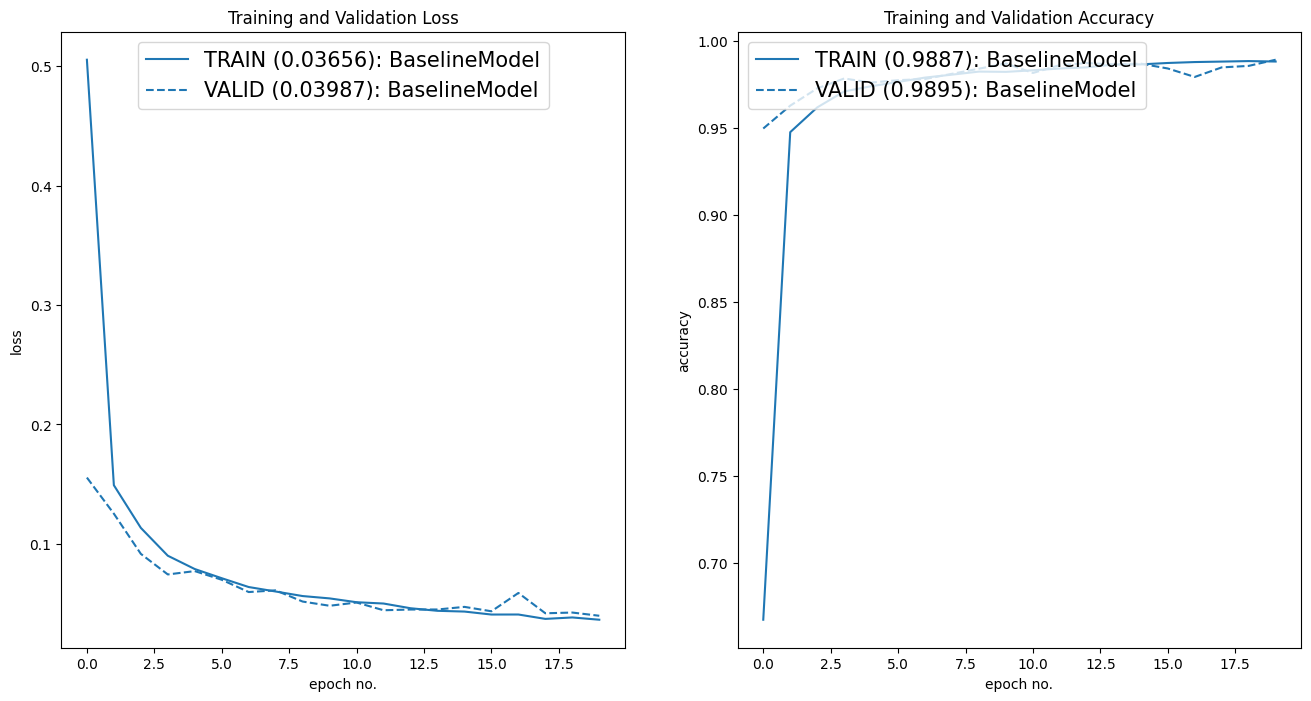

In [33]:
plot_loss_accuracy(train_loss= [train_losses],
                   val_loss= [test_losses],
                   train_acc= [train_metrics],
                   val_acc= [test_metrics],
                   labels=['BaselineModel'],
                   colors=['blue'],
                   loss_legend_loc='upper center',
                   acc_legend_loc='upper left')

### Application of Batchnorm and dropouts

In [62]:
class MnistBaseline_BNDR(nn.Module):
    """Feedfoward neural network with 2 Cnn blocks and 1 hidden layer and BN and DPR"""
    def __init__(self, in_channels, hidden_units, out_channels):
        super(MnistBaseline_BNDR, self).__init__()
        # Input starts with (28,28)
        # each conv block is like [conv->relu->conv->relu->maxpool]

        self.block1 = nn.Sequential(
            nn.Conv2d(in_channels = in_channels,
                      out_channels = hidden_units,
                      kernel_size=(3,3),
                      stride=1,
                     padding=0), #(26,26,HDUN)
            nn.BatchNorm2d(hidden_units),
            nn.ReLU(),
            nn.Conv2d(in_channels = hidden_units,
                      out_channels= hidden_units,
                      kernel_size=(3,3),
                      stride=1,
                      padding=0
            ), #(24,24,HDUN)
            nn.BatchNorm2d(hidden_units),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,2),
                         stride=(2,2)), #(12,12,HDUN)

            nn.Dropout(p=0.1)
        )

        self.block2 = nn.Sequential(
            nn.Conv2d(in_channels = hidden_units,
                      out_channels = hidden_units,
                      kernel_size=(3,3),
                      stride=1,
                      padding=0), #(10,10,HDUN)
            nn.BatchNorm2d(hidden_units),
            nn.ReLU(),
            nn.Conv2d(in_channels = hidden_units,
                      out_channels =hidden_units,
                      kernel_size=(3,3),
                      stride=1,
                      padding=0), #(8,8,HDUN)
            nn.BatchNorm2d(hidden_units),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,2),
                         stride=(2,2)), #(4,4,HDUN)

            nn.Dropout(p=0.1)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(4*4*hidden_units, out_channels*10),
            nn.BatchNorm1d(out_channels*10),
            nn.ReLU(),
            nn.Linear(out_channels*10, out_channels*5),
            nn.BatchNorm1d(out_channels*5),
            nn.ReLU(),
            nn.Linear(out_channels*5, out_channels)
        )

    def forward(self, x):
      """Forward propagation"""
      x = self.block1(x)
      x = self.block2(x)
      x = self.classifier(x)

      return x

In [63]:
# New Model Instance
normalized_model = MnistBaseline_BNDR(in_channels=1,
                                           hidden_units=8,
                                           out_channels=10).to(device)
summary(normalized_model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              80
       BatchNorm2d-2            [-1, 8, 26, 26]              16
              ReLU-3            [-1, 8, 26, 26]               0
            Conv2d-4            [-1, 8, 24, 24]             584
       BatchNorm2d-5            [-1, 8, 24, 24]              16
              ReLU-6            [-1, 8, 24, 24]               0
         MaxPool2d-7            [-1, 8, 12, 12]               0
           Dropout-8            [-1, 8, 12, 12]               0
            Conv2d-9            [-1, 8, 10, 10]             584
      BatchNorm2d-10            [-1, 8, 10, 10]              16
             ReLU-11            [-1, 8, 10, 10]               0
           Conv2d-12              [-1, 8, 8, 8]             584
      BatchNorm2d-13              [-1, 8, 8, 8]              16
             ReLU-14              [-1, 

In [64]:
# driver setup----
# optmizer
optimizer = optim.Adam(normalized_model.parameters(), lr=lr)
# loss
criterion = nn.CrossEntropyLoss()
# metric
metric = MulticlassAccuracy(device = device, num_classes=10)
# Early stopping
early_stopping = EarlyStopping(patience=5, verbose=True)

In [65]:
train_losses = []
train_metrics = []
test_losses = []
test_metrics = []

for epoch in range(0,epochs):
  print(f'Epoch {epoch}')
  train_losses, train_metrics = train_module(normalized_model, device, train_loader, optimizer, criterion, metric, train_losses, train_metrics)
  test_losses , test_metrics = test_module(normalized_model, device, test_loader, criterion, metric, test_losses, test_metrics)
  early_stopping(test_losses[-1], normalized_model, epoch) # last recorded test loss to measure the improvement against the prior one
  if early_stopping.early_stop:
    print("Early stopping")
    break

Epoch 0


Avg Train Loss: 0.4191712938598605 Avg Train Metric: 0.7760775994612719: 100%|██████████| 469/469 [00:38<00:00, 12.12it/s]


Function Took 38.6914 seconds


Avg Test Loss: 0.08902628618422188 Avg Test Metric: 0.9733227242397356: 100%|██████████| 79/79 [00:06<00:00, 13.06it/s]


Function Took 6.0554 seconds
Validation loss decreased (inf --> 0.089026).  Saving model ...
Epoch 1


Avg Train Loss: 0.11499715062664516 Avg Train Metric: 0.9624193991933551: 100%|██████████| 469/469 [00:38<00:00, 12.12it/s]


Function Took 38.7066 seconds


Avg Test Loss: 0.0640449265631128 Avg Test Metric: 0.9816056987907313: 100%|██████████| 79/79 [00:06<00:00, 13.01it/s]


Function Took 6.0754 seconds
Validation loss decreased (0.089026 --> 0.064045).  Saving model ...
Epoch 2


Avg Train Loss: 0.08999184271229356 Avg Train Metric: 0.9700961158728041: 100%|██████████| 469/469 [00:39<00:00, 12.02it/s]


Function Took 39.0382 seconds


Avg Test Loss: 0.04309740256373711 Avg Test Metric: 0.9861612863178495: 100%|██████████| 79/79 [00:05<00:00, 13.20it/s]


Function Took 5.9891 seconds
Validation loss decreased (0.064045 --> 0.043097).  Saving model ...
Epoch 3


Avg Train Loss: 0.07571391665390623 Avg Train Metric: 0.9765693338186756: 100%|██████████| 469/469 [00:37<00:00, 12.35it/s]


Function Took 37.9808 seconds


Avg Test Loss: 0.042802538942321666 Avg Test Metric: 0.9843159348149843: 100%|██████████| 79/79 [00:06<00:00, 13.03it/s]


Function Took 6.0683 seconds
Validation loss decreased (0.043097 --> 0.042803).  Saving model ...
Epoch 4


Avg Train Loss: 0.06865666236386879 Avg Train Metric: 0.9773812971389624: 100%|██████████| 469/469 [00:37<00:00, 12.35it/s]


Function Took 37.9668 seconds


Avg Test Loss: 0.044563578353322385 Avg Test Metric: 0.985147255130961: 100%|██████████| 79/79 [00:05<00:00, 13.39it/s]


Function Took 5.9037 seconds
EarlyStopping counter: 1 out of 5
Epoch 5


Avg Train Loss: 0.06486557794611718 Avg Train Metric: 0.9804220402927033: 100%|██████████| 469/469 [00:37<00:00, 12.36it/s]


Function Took 37.9581 seconds


Avg Test Loss: 0.04049275767152445 Avg Test Metric: 0.9885248428658594: 100%|██████████| 79/79 [00:05<00:00, 13.20it/s]


Function Took 5.9920 seconds
Validation loss decreased (0.042803 --> 0.040493).  Saving model ...
Epoch 6


Avg Train Loss: 0.061248071910714165 Avg Train Metric: 0.9802653621763054: 100%|██████████| 469/469 [00:37<00:00, 12.39it/s]


Function Took 37.8554 seconds


Avg Test Loss: 0.030976994313841946 Avg Test Metric: 0.990626685981509: 100%|██████████| 79/79 [00:06<00:00, 13.04it/s]


Function Took 6.0640 seconds
Validation loss decreased (0.040493 --> 0.030977).  Saving model ...
Epoch 7


Avg Train Loss: 0.05594532756901372 Avg Train Metric: 0.9825381057094663: 100%|██████████| 469/469 [00:37<00:00, 12.39it/s]


Function Took 37.8597 seconds


Avg Test Loss: 0.03633089436518759 Avg Test Metric: 0.9879092740107186: 100%|██████████| 79/79 [00:05<00:00, 13.20it/s]


Function Took 5.9896 seconds
EarlyStopping counter: 1 out of 5
Epoch 8


Avg Train Loss: 0.055923119082606075 Avg Train Metric: 0.9825710556400356: 100%|██████████| 469/469 [00:37<00:00, 12.34it/s]


Function Took 37.9984 seconds


Avg Test Loss: 0.0317999397999831 Avg Test Metric: 0.9892557580259782: 100%|██████████| 79/79 [00:05<00:00, 13.45it/s]


Function Took 5.8803 seconds
EarlyStopping counter: 2 out of 5
Epoch 9


Avg Train Loss: 0.05352224864716977 Avg Train Metric: 0.9832093612725801: 100%|██████████| 469/469 [00:38<00:00, 12.17it/s]


Function Took 38.5489 seconds


Avg Test Loss: 0.030837569211880807 Avg Test Metric: 0.9900260205510296: 100%|██████████| 79/79 [00:05<00:00, 13.18it/s]


Function Took 5.9968 seconds
Validation loss decreased (0.030977 --> 0.030838).  Saving model ...
Epoch 10


Avg Train Loss: 0.05048322533346665 Avg Train Metric: 0.9840395887777496: 100%|██████████| 469/469 [00:38<00:00, 12.33it/s]


Function Took 38.0462 seconds


Avg Test Loss: 0.030011888390076878 Avg Test Metric: 0.9900619591338725: 100%|██████████| 79/79 [00:05<00:00, 13.31it/s]


Function Took 5.9405 seconds
Validation loss decreased (0.030838 --> 0.030012).  Saving model ...
Epoch 11


Avg Train Loss: 0.05033849369087167 Avg Train Metric: 0.9846273104010869: 100%|██████████| 469/469 [00:38<00:00, 12.32it/s]


Function Took 38.0683 seconds


Avg Test Loss: 0.032503825482688375 Avg Test Metric: 0.9886635036408147: 100%|██████████| 79/79 [00:06<00:00, 13.13it/s]


Function Took 6.0235 seconds
EarlyStopping counter: 1 out of 5
Epoch 12


Avg Train Loss: 0.04835897768492193 Avg Train Metric: 0.9845727452082929: 100%|██████████| 469/469 [00:37<00:00, 12.42it/s]


Function Took 37.7738 seconds


Avg Test Loss: 0.029089870397001505 Avg Test Metric: 0.9906242904783804: 100%|██████████| 79/79 [00:05<00:00, 13.44it/s]


Function Took 5.8829 seconds
Validation loss decreased (0.030012 --> 0.029090).  Saving model ...
Epoch 13


Avg Train Loss: 0.04723858726876123 Avg Train Metric: 0.9851640644612343: 100%|██████████| 469/469 [00:38<00:00, 12.25it/s]


Function Took 38.2834 seconds


Avg Test Loss: 0.027870017310156474 Avg Test Metric: 0.9904653196093403: 100%|██████████| 79/79 [00:05<00:00, 13.28it/s]


Function Took 5.9542 seconds
Validation loss decreased (0.029090 --> 0.027870).  Saving model ...
Epoch 14


Avg Train Loss: 0.045214604455302516 Avg Train Metric: 0.9859908262549687: 100%|██████████| 469/469 [00:37<00:00, 12.48it/s]


Function Took 37.5915 seconds


Avg Test Loss: 0.031679096986109365 Avg Test Metric: 0.9910107805759092: 100%|██████████| 79/79 [00:06<00:00, 12.99it/s]


Function Took 6.0856 seconds
EarlyStopping counter: 1 out of 5
Epoch 15


Avg Train Loss: 0.045875724427886545 Avg Train Metric: 0.9854117218873648: 100%|██████████| 469/469 [00:37<00:00, 12.36it/s]


Function Took 37.9414 seconds


Avg Test Loss: 0.031356311407267363 Avg Test Metric: 0.9900992429709132: 100%|██████████| 79/79 [00:05<00:00, 13.25it/s]


Function Took 5.9693 seconds
EarlyStopping counter: 2 out of 5
Epoch 16


Avg Train Loss: 0.04345707414743266 Avg Train Metric: 0.9867812406533817: 100%|██████████| 469/469 [00:37<00:00, 12.39it/s]


Function Took 37.8693 seconds


Avg Test Loss: 0.031988590386920146 Avg Test Metric: 0.990994510771353: 100%|██████████| 79/79 [00:06<00:00, 13.14it/s]


Function Took 6.0184 seconds
EarlyStopping counter: 3 out of 5
Epoch 17


Avg Train Loss: 0.04289296205425615 Avg Train Metric: 0.9857038742443646: 100%|██████████| 469/469 [00:38<00:00, 12.30it/s]


Function Took 38.1375 seconds


Avg Test Loss: 0.03224654276221637 Avg Test Metric: 0.9895212635209288: 100%|██████████| 79/79 [00:06<00:00, 13.04it/s]


Function Took 6.0649 seconds
EarlyStopping counter: 4 out of 5
Epoch 18


Avg Train Loss: 0.042565329939122994 Avg Train Metric: 0.9868428151744769: 100%|██████████| 469/469 [00:37<00:00, 12.40it/s]


Function Took 37.8268 seconds


Avg Test Loss: 0.02878260473968296 Avg Test Metric: 0.9914473061320148: 100%|██████████| 79/79 [00:05<00:00, 13.51it/s]

Function Took 5.8544 seconds
EarlyStopping counter: 5 out of 5
Early stopping


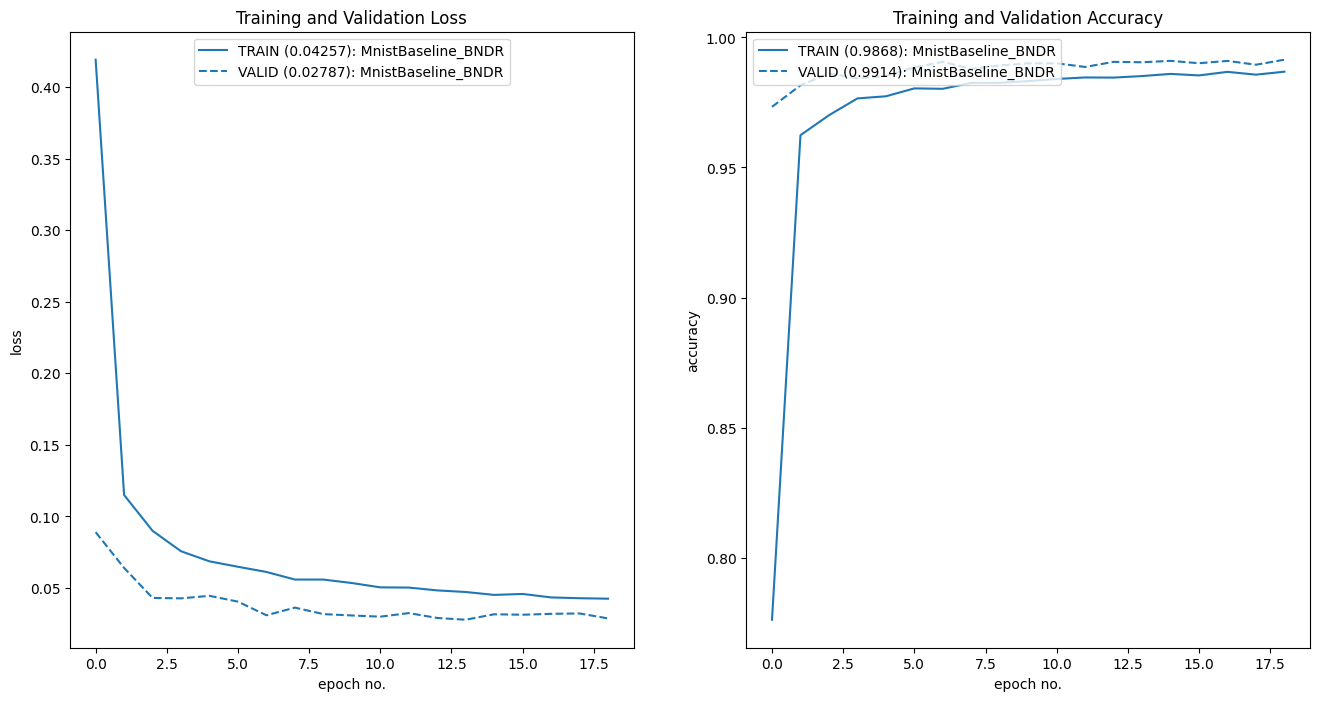

In [70]:
plot_loss_accuracy(train_loss= [train_losses],
                   val_loss= [test_losses],
                   train_acc= [train_metrics],
                   val_acc= [test_metrics],
                   labels=['MnistBaseline_BNDR'],
                   colors=['blue'],
                   loss_legend_loc='upper center',
                   acc_legend_loc='upper left')

In [41]:
class MnistBaseline_BNDR_v2(nn.Module):
    """Feedfoward neural network with 2 Cnn blocks and 1 hidden layer and BN and DPR"""
    def __init__(self, in_channels, hidden_units, out_channels):
        super(MnistBaseline_BNDR_v2, self).__init__()
        # Input starts with (28,28)
        # each conv block is like [conv->relu->conv->relu->maxpool]

        self.block1 = nn.Sequential(
            nn.Conv2d(in_channels = in_channels,
                      out_channels = hidden_units,
                      kernel_size=(3,3),
                      stride=1,
                     padding=0), #(26,26,HDUN)
            nn.BatchNorm2d(hidden_units),
            nn.ReLU(),
            nn.Conv2d(in_channels = hidden_units,
                      out_channels= hidden_units,
                      kernel_size=(3,3),
                      stride=1,
                      padding=0
            ), #(24,24,HDUN)
            nn.BatchNorm2d(hidden_units),
            nn.ReLU(),
            nn.Dropout(p=0.1),
            nn.MaxPool2d(kernel_size=(2,2),
                         stride=(2,2)), #(12,12,HDUN)
        )

        self.block2 = nn.Sequential(
            nn.Conv2d(in_channels = hidden_units,
                      out_channels = hidden_units,
                      kernel_size=(3,3),
                      stride=1,
                      padding=0), #(10,10,HDUN)
            nn.BatchNorm2d(hidden_units),
            nn.ReLU(),
            nn.Conv2d(in_channels = hidden_units,
                      out_channels =hidden_units,
                      kernel_size=(3,3),
                      stride=1,
                      padding=0), #(8,8,HDUN)
            nn.BatchNorm2d(hidden_units),
            nn.ReLU(),
            nn.Dropout(p=0.1),
            nn.MaxPool2d(kernel_size=(2,2),
                         stride=(2,2)), #(4,4,HDUN)

        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(4*4*hidden_units, out_channels*10),
            nn.BatchNorm1d(out_channels*10),
            nn.ReLU(),
            nn.Dropout(p=0.1),
            nn.Linear(out_channels*10, out_channels*5),
            nn.BatchNorm1d(out_channels*5),
            nn.ReLU(),
            nn.Linear(out_channels*5, out_channels)
        )

    def forward(self, x):
      """Forward propagation"""
      x = self.block1(x)
      x = self.block2(x)
      x = self.classifier(x)

      return x

In [42]:
# New Model Instance
normalized_model_v2 = MnistBaseline_BNDR_v2(in_channels=1,
                                           hidden_units=8,
                                           out_channels=10).to(device)
summary(normalized_model_v2, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              80
       BatchNorm2d-2            [-1, 8, 26, 26]              16
              ReLU-3            [-1, 8, 26, 26]               0
            Conv2d-4            [-1, 8, 24, 24]             584
       BatchNorm2d-5            [-1, 8, 24, 24]              16
              ReLU-6            [-1, 8, 24, 24]               0
           Dropout-7            [-1, 8, 24, 24]               0
         MaxPool2d-8            [-1, 8, 12, 12]               0
            Conv2d-9            [-1, 8, 10, 10]             584
      BatchNorm2d-10            [-1, 8, 10, 10]              16
             ReLU-11            [-1, 8, 10, 10]               0
           Conv2d-12              [-1, 8, 8, 8]             584
      BatchNorm2d-13              [-1, 8, 8, 8]              16
             ReLU-14              [-1, 

In [43]:
# driver setup----
# optmizer
optimizer = optim.Adam(normalized_model_v2.parameters(), lr=lr)
# loss
criterion = nn.CrossEntropyLoss()
# metric
metric = MulticlassAccuracy(device = device, num_classes=10)
# Early stopping
early_stopping = EarlyStopping(patience=5, verbose=True)

In [44]:
train_losses = []
train_metrics = []
test_losses = []
test_metrics = []

for epoch in range(0,epochs):
  print(f'Epoch {epoch}')
  train_losses, train_metrics = train_module(normalized_model_v2, device, train_loader, optimizer, criterion, metric, train_losses, train_metrics)
  test_losses , test_metrics = test_module(normalized_model_v2, device, test_loader, criterion, metric, test_losses, test_metrics)
  early_stopping(test_losses[-1], normalized_model_v2, epoch) # last recorded test loss to measure the improvement against the prior one
  if early_stopping.early_stop:
    print("Early stopping")
    break

Epoch 0


Avg Train Loss: 0.3730073320522491 Avg Train Metric: 0.807776875984567: 100%|██████████| 469/469 [00:39<00:00, 12.00it/s]


Function Took 39.0918 seconds


Avg Test Loss: 0.09149752760046645 Avg Test Metric: 0.9776483442209944: 100%|██████████| 79/79 [00:06<00:00, 12.75it/s]


Function Took 6.2042 seconds
Validation loss decreased (inf --> 0.091498).  Saving model ...
Epoch 1


Avg Train Loss: 0.09584235277241354 Avg Train Metric: 0.970045206007927: 100%|██████████| 469/469 [00:39<00:00, 11.95it/s]


Function Took 39.2387 seconds


Avg Test Loss: 0.06662272110793598 Avg Test Metric: 0.9820973397810248: 100%|██████████| 79/79 [00:06<00:00, 12.85it/s]


Function Took 6.1539 seconds
Validation loss decreased (0.091498 --> 0.066623).  Saving model ...
Epoch 2


Avg Train Loss: 0.07305558332041509 Avg Train Metric: 0.9765345921902768: 100%|██████████| 469/469 [00:38<00:00, 12.07it/s]


Function Took 38.8630 seconds


Avg Test Loss: 0.04964273617178484 Avg Test Metric: 0.9862181076520606: 100%|██████████| 79/79 [00:06<00:00, 13.17it/s]


Function Took 6.0053 seconds
Validation loss decreased (0.066623 --> 0.049643).  Saving model ...
Epoch 3


Avg Train Loss: 0.06099735590309572 Avg Train Metric: 0.9809031590724042: 100%|██████████| 469/469 [00:39<00:00, 11.89it/s]


Function Took 39.4374 seconds


Avg Test Loss: 0.04302011240462336 Avg Test Metric: 0.9867307475850552: 100%|██████████| 79/79 [00:06<00:00, 12.99it/s]


Function Took 6.0861 seconds
Validation loss decreased (0.049643 --> 0.043020).  Saving model ...
Epoch 4


Avg Train Loss: 0.055002851237946036 Avg Train Metric: 0.9837439039876974: 100%|██████████| 469/469 [00:38<00:00, 12.10it/s]


Function Took 38.7539 seconds


Avg Test Loss: 0.046753128766541995 Avg Test Metric: 0.9856345615809476: 100%|██████████| 79/79 [00:06<00:00, 12.99it/s]


Function Took 6.0885 seconds
EarlyStopping counter: 1 out of 5
Epoch 5


Avg Train Loss: 0.05053499315891153 Avg Train Metric: 0.9843227243118449: 100%|██████████| 469/469 [00:38<00:00, 12.16it/s]


Function Took 38.5908 seconds


Avg Test Loss: 0.04191470564684913 Avg Test Metric: 0.9861166273491292: 100%|██████████| 79/79 [00:06<00:00, 12.74it/s]


Function Took 6.2076 seconds
Validation loss decreased (0.043020 --> 0.041915).  Saving model ...
Epoch 6


Avg Train Loss: 0.048041460783417415 Avg Train Metric: 0.9841670818420362: 100%|██████████| 469/469 [00:38<00:00, 12.10it/s]


Function Took 38.7668 seconds


Avg Test Loss: 0.03630643355648352 Avg Test Metric: 0.9874791963190972: 100%|██████████| 79/79 [00:06<00:00, 13.15it/s]


Function Took 6.0142 seconds
Validation loss decreased (0.041915 --> 0.036306).  Saving model ...
Epoch 7


Avg Train Loss: 0.045902968104333 Avg Train Metric: 0.9857104355846641: 100%|██████████| 469/469 [00:39<00:00, 12.00it/s]


Function Took 39.0755 seconds


Avg Test Loss: 0.037606430841209015 Avg Test Metric: 0.9901204033742977: 100%|██████████| 79/79 [00:06<00:00, 13.13it/s]


Function Took 6.0233 seconds
EarlyStopping counter: 1 out of 5
Epoch 8


Avg Train Loss: 0.042613382524709455 Avg Train Metric: 0.9870381348931205: 100%|██████████| 469/469 [00:39<00:00, 11.92it/s]


Function Took 39.3486 seconds


Avg Test Loss: 0.03523469795885531 Avg Test Metric: 0.9869924512090562: 100%|██████████| 79/79 [00:06<00:00, 12.70it/s]


Function Took 6.2292 seconds
Validation loss decreased (0.036306 --> 0.035235).  Saving model ...
Epoch 9


Avg Train Loss: 0.044718332438251136 Avg Train Metric: 0.9859759317023922: 100%|██████████| 469/469 [00:39<00:00, 11.98it/s]


Function Took 39.1528 seconds


Avg Test Loss: 0.03462562363748026 Avg Test Metric: 0.989754206772092: 100%|██████████| 79/79 [00:06<00:00, 12.70it/s]


Function Took 6.2277 seconds
Validation loss decreased (0.035235 --> 0.034626).  Saving model ...
Epoch 10


Avg Train Loss: 0.04118604830819676 Avg Train Metric: 0.9869210584077246: 100%|██████████| 469/469 [00:38<00:00, 12.14it/s]


Function Took 38.6301 seconds


Avg Test Loss: 0.03666798059557435 Avg Test Metric: 0.9900366007527218: 100%|██████████| 79/79 [00:06<00:00, 13.03it/s]


Function Took 6.0669 seconds
EarlyStopping counter: 1 out of 5
Epoch 11


Avg Train Loss: 0.03892806148789982 Avg Train Metric: 0.9888953266621653: 100%|██████████| 469/469 [00:38<00:00, 12.23it/s]


Function Took 38.3667 seconds


Avg Test Loss: 0.03702242672148667 Avg Test Metric: 0.9899046436140809: 100%|██████████| 79/79 [00:06<00:00, 12.89it/s]


Function Took 6.1358 seconds
EarlyStopping counter: 2 out of 5
Epoch 12


Avg Train Loss: 0.03699218557784155 Avg Train Metric: 0.9883711640514544: 100%|██████████| 469/469 [00:38<00:00, 12.15it/s]


Function Took 38.6130 seconds


Avg Test Loss: 0.031661095793205724 Avg Test Metric: 0.9887029287181323: 100%|██████████| 79/79 [00:06<00:00, 13.09it/s]


Function Took 6.0398 seconds
Validation loss decreased (0.034626 --> 0.031661).  Saving model ...
Epoch 13


Avg Train Loss: 0.03789601728284378 Avg Train Metric: 0.9879221702689556: 100%|██████████| 469/469 [00:39<00:00, 11.98it/s]


Function Took 39.1386 seconds


Avg Test Loss: 0.03353568141885055 Avg Test Metric: 0.988865748236451: 100%|██████████| 79/79 [00:06<00:00, 11.85it/s]


Function Took 6.6725 seconds
EarlyStopping counter: 1 out of 5
Epoch 14


Avg Train Loss: 0.037639798360195625 Avg Train Metric: 0.9879152974340198: 100%|██████████| 469/469 [00:40<00:00, 11.58it/s]


Function Took 40.5062 seconds


Avg Test Loss: 0.03351205245214455 Avg Test Metric: 0.9890119425858124: 100%|██████████| 79/79 [00:06<00:00, 12.70it/s]


Function Took 6.2253 seconds
EarlyStopping counter: 2 out of 5
Epoch 15


Avg Train Loss: 0.03512746713279105 Avg Train Metric: 0.9896015728206269: 100%|██████████| 469/469 [00:39<00:00, 11.88it/s]


Function Took 39.4962 seconds


Avg Test Loss: 0.03227897821277191 Avg Test Metric: 0.9910415893868555: 100%|██████████| 79/79 [00:06<00:00, 12.79it/s]


Function Took 6.1812 seconds
EarlyStopping counter: 3 out of 5
Epoch 16


Avg Train Loss: 0.03334457459631187 Avg Train Metric: 0.9884660029207973: 100%|██████████| 469/469 [00:39<00:00, 11.98it/s]


Function Took 39.1675 seconds


Avg Test Loss: 0.03696179130303237 Avg Test Metric: 0.9879857528058789: 100%|██████████| 79/79 [00:06<00:00, 13.07it/s]


Function Took 6.0500 seconds
EarlyStopping counter: 4 out of 5
Epoch 17


Avg Train Loss: 0.03293289128752517 Avg Train Metric: 0.9896375403475406: 100%|██████████| 469/469 [00:39<00:00, 11.91it/s]


Function Took 39.3730 seconds


Avg Test Loss: 0.03104785138363891 Avg Test Metric: 0.9885337828080866: 100%|██████████| 79/79 [00:06<00:00, 12.89it/s]


Function Took 6.1346 seconds
Validation loss decreased (0.031661 --> 0.031048).  Saving model ...
Epoch 18


Avg Train Loss: 0.03480977015738596 Avg Train Metric: 0.9895213020127466: 100%|██████████| 469/469 [00:39<00:00, 11.95it/s]


Function Took 39.2625 seconds


Avg Test Loss: 0.030243870787487567 Avg Test Metric: 0.9898063465009762: 100%|██████████| 79/79 [00:06<00:00, 12.71it/s]


Function Took 6.2222 seconds
Validation loss decreased (0.031048 --> 0.030244).  Saving model ...
Epoch 19


Avg Train Loss: 0.030008084611343678 Avg Train Metric: 0.9904009997209252: 100%|██████████| 469/469 [00:39<00:00, 11.95it/s]


Function Took 39.2604 seconds


Avg Test Loss: 0.028222794774212415 Avg Test Metric: 0.9892018165769456: 100%|██████████| 79/79 [00:06<00:00, 12.67it/s]

Function Took 6.2421 seconds
Validation loss decreased (0.030244 --> 0.028223).  Saving model ...


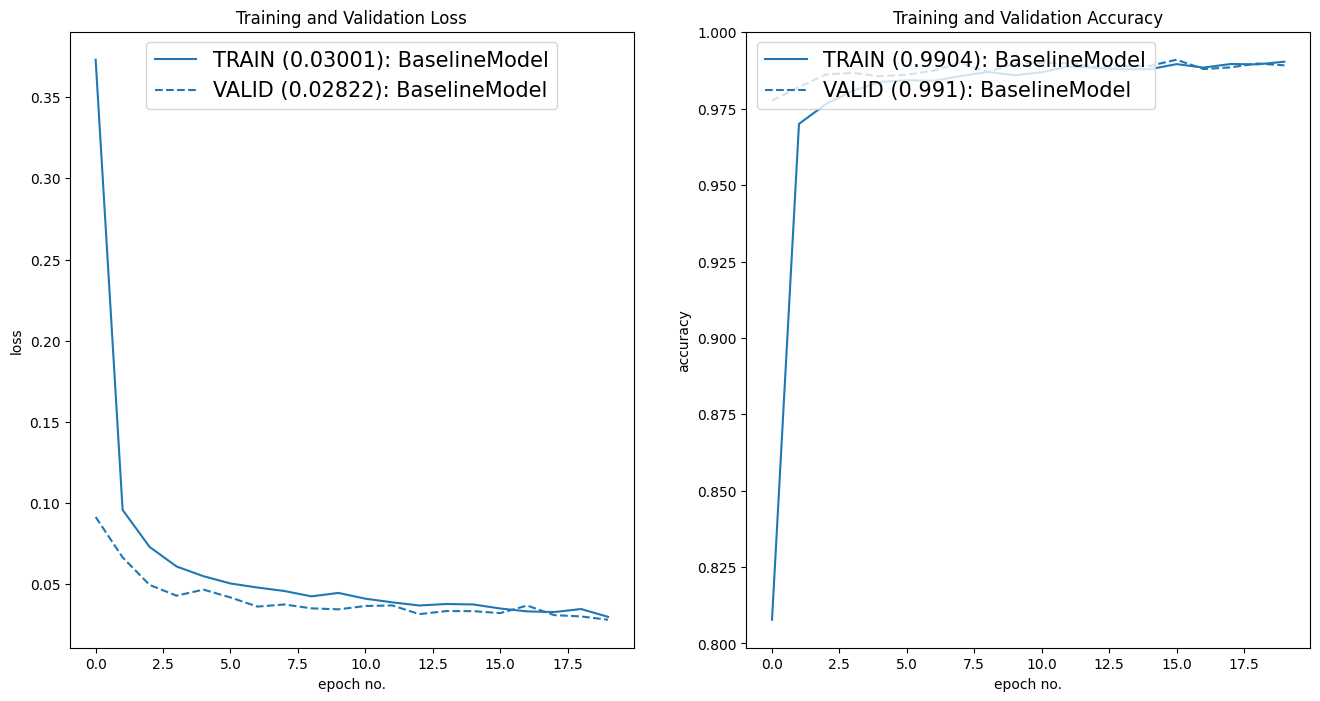

In [45]:
plot_loss_accuracy(train_loss= [train_losses],
                   val_loss= [test_losses],
                   train_acc= [train_metrics],
                   val_acc= [test_metrics],
                   labels=['BaselineModel'],
                   colors=['blue'],
                   loss_legend_loc='upper center',
                   acc_legend_loc='upper left')

In [47]:
class MnistBaseline_BNDR_v3(nn.Module):
    """Feedfoward neural network with 2 Cnn blocks and 1 hidden layer and BN and DPR"""
    def __init__(self, in_channels, hidden_units, out_channels):
        super(MnistBaseline_BNDR_v3, self).__init__()
        # Input starts with (28,28)
        # each conv block is like [conv->relu->conv->relu->maxpool]

        self.block1 = nn.Sequential(
            nn.Conv2d(in_channels = in_channels,
                      out_channels = hidden_units,
                      kernel_size=(3,3),
                      stride=1,
                     padding=0), #(26,26,HDUN)
            nn.BatchNorm2d(hidden_units),
            nn.ReLU(),
            nn.Conv2d(in_channels = hidden_units,
                      out_channels= hidden_units,
                      kernel_size=(3,3),
                      stride=1,
                      padding=0
            ), #(24,24,HDUN)
            nn.BatchNorm2d(hidden_units),
            nn.ReLU(),
            nn.Dropout(p=0.1),
            nn.MaxPool2d(kernel_size=(2,2),
                         stride=(2,2)), #(12,12,HDUN)
        )

        self.block2 = nn.Sequential(
            nn.Conv2d(in_channels = hidden_units,
                      out_channels = hidden_units,
                      kernel_size=(3,3),
                      stride=1,
                      padding=0), #(10,10,HDUN)
            nn.BatchNorm2d(hidden_units),
            nn.ReLU(),
            nn.Conv2d(in_channels = hidden_units,
                      out_channels =hidden_units,
                      kernel_size=(3,3),
                      stride=1,
                      padding=0), #(8,8,HDUN)
            nn.BatchNorm2d(hidden_units),
            nn.ReLU(),
            nn.Dropout(p=0.1),
            nn.MaxPool2d(kernel_size=(2,2),
                         stride=(2,2)), #(4,4,HDUN)

        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(4*4*hidden_units, out_channels*10),
            nn.BatchNorm1d(out_channels*10),
            nn.ReLU(),
            nn.Linear(out_channels*10, out_channels*5),
            nn.BatchNorm1d(out_channels*5),
            nn.ReLU(),
            nn.Linear(out_channels*5, out_channels)
        )

    def forward(self, x):
      """Forward propagation"""
      x = self.block1(x)
      x = self.block2(x)
      x = self.classifier(x)

      return x

In [49]:
# New Model Instance
normalized_model_v3 = MnistBaseline_BNDR_v3(in_channels=1,
                                           hidden_units=8,
                                           out_channels=10).to(device)
summary(normalized_model_v3, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              80
       BatchNorm2d-2            [-1, 8, 26, 26]              16
              ReLU-3            [-1, 8, 26, 26]               0
            Conv2d-4            [-1, 8, 24, 24]             584
       BatchNorm2d-5            [-1, 8, 24, 24]              16
              ReLU-6            [-1, 8, 24, 24]               0
           Dropout-7            [-1, 8, 24, 24]               0
         MaxPool2d-8            [-1, 8, 12, 12]               0
            Conv2d-9            [-1, 8, 10, 10]             584
      BatchNorm2d-10            [-1, 8, 10, 10]              16
             ReLU-11            [-1, 8, 10, 10]               0
           Conv2d-12              [-1, 8, 8, 8]             584
      BatchNorm2d-13              [-1, 8, 8, 8]              16
             ReLU-14              [-1, 

In [50]:
# driver setup----
# optmizer
optimizer = optim.Adam(normalized_model_v3.parameters(), lr=lr)
# loss
criterion = nn.CrossEntropyLoss()
# metric
metric = MulticlassAccuracy(device = device, num_classes=10)
# Early stopping
early_stopping = EarlyStopping(patience=5, verbose=True)

In [51]:
train_losses = []
train_metrics = []
test_losses = []
test_metrics = []

for epoch in range(0,epochs):
  print(f'Epoch {epoch}')
  train_losses, train_metrics = train_module(normalized_model_v3, device, train_loader, optimizer, criterion, metric, train_losses, train_metrics)
  test_losses , test_metrics = test_module(normalized_model_v3, device, test_loader, criterion, metric, test_losses, test_metrics)
  early_stopping(test_losses[-1], normalized_model_v3, epoch) # last recorded test loss to measure the improvement against the prior one
  if early_stopping.early_stop:
    print("Early stopping")
    break

Epoch 0


Avg Train Loss: 0.375269863452675 Avg Train Metric: 0.7998113806949241: 100%|██████████| 469/469 [00:39<00:00, 11.99it/s]


Function Took 39.1118 seconds


Avg Test Loss: 0.09713293140447593 Avg Test Metric: 0.9743652969976014: 100%|██████████| 79/79 [00:06<00:00, 12.59it/s]


Function Took 6.2807 seconds
Validation loss decreased (inf --> 0.097133).  Saving model ...
Epoch 1


Avg Train Loss: 0.08646585008324083 Avg Train Metric: 0.9728397423270415: 100%|██████████| 469/469 [00:39<00:00, 12.02it/s]


Function Took 39.0409 seconds


Avg Test Loss: 0.06561588361576388 Avg Test Metric: 0.9827784179132196: 100%|██████████| 79/79 [00:06<00:00, 12.73it/s]


Function Took 6.2120 seconds
Validation loss decreased (0.097133 --> 0.065616).  Saving model ...
Epoch 2


Avg Train Loss: 0.06543716973960717 Avg Train Metric: 0.9791663525455288: 100%|██████████| 469/469 [00:39<00:00, 11.86it/s]


Function Took 39.5451 seconds


Avg Test Loss: 0.05095856105083529 Avg Test Metric: 0.9861212750024433: 100%|██████████| 79/79 [00:06<00:00, 12.78it/s]


Function Took 6.1887 seconds
Validation loss decreased (0.065616 --> 0.050959).  Saving model ...
Epoch 3


Avg Train Loss: 0.057230720912088466 Avg Train Metric: 0.9818888875975538: 100%|██████████| 469/469 [00:39<00:00, 11.92it/s]


Function Took 39.3441 seconds


Avg Test Loss: 0.04446097348427659 Avg Test Metric: 0.9848143005672889: 100%|██████████| 79/79 [00:06<00:00, 13.07it/s]


Function Took 6.0480 seconds
Validation loss decreased (0.050959 --> 0.044461).  Saving model ...
Epoch 4


Avg Train Loss: 0.04922003935534022 Avg Train Metric: 0.9848806977526211: 100%|██████████| 469/469 [00:39<00:00, 11.89it/s]


Function Took 39.4638 seconds


Avg Test Loss: 0.04492600494995713 Avg Test Metric: 0.9821369746063329: 100%|██████████| 79/79 [00:06<00:00, 12.98it/s]


Function Took 6.0933 seconds
EarlyStopping counter: 1 out of 5
Epoch 5


Avg Train Loss: 0.04541552336866667 Avg Train Metric: 0.98584311806571: 100%|██████████| 469/469 [00:39<00:00, 11.89it/s]


Function Took 39.4592 seconds


Avg Test Loss: 0.04509333424532456 Avg Test Metric: 0.986851376068743: 100%|██████████| 79/79 [00:06<00:00, 12.13it/s]


Function Took 6.5183 seconds
EarlyStopping counter: 2 out of 5
Epoch 6


Avg Train Loss: 0.042358806108567376 Avg Train Metric: 0.9874337607863616: 100%|██████████| 469/469 [00:40<00:00, 11.48it/s]


Function Took 40.8674 seconds


Avg Test Loss: 0.04011364364068177 Avg Test Metric: 0.9862681529189967: 100%|██████████| 79/79 [00:06<00:00, 12.40it/s]


Function Took 6.3778 seconds
Validation loss decreased (0.044461 --> 0.040114).  Saving model ...
Epoch 7


Avg Train Loss: 0.04161891842614422 Avg Train Metric: 0.9863267704876247: 100%|██████████| 469/469 [00:39<00:00, 11.74it/s]


Function Took 39.9479 seconds


Avg Test Loss: 0.03911739325480936 Avg Test Metric: 0.9869853046875966: 100%|██████████| 79/79 [00:06<00:00, 12.59it/s]


Function Took 6.2799 seconds
Validation loss decreased (0.040114 --> 0.039117).  Saving model ...
Epoch 8


Avg Train Loss: 0.040296672752548036 Avg Train Metric: 0.9875962546130995: 100%|██████████| 469/469 [00:39<00:00, 11.92it/s]


Function Took 39.3457 seconds


Avg Test Loss: 0.03310753424987904 Avg Test Metric: 0.9888593018809452: 100%|██████████| 79/79 [00:06<00:00, 12.66it/s]


Function Took 6.2475 seconds
Validation loss decreased (0.039117 --> 0.033108).  Saving model ...
Epoch 9


Avg Train Loss: 0.03464334413730927 Avg Train Metric: 0.9889141087338869: 100%|██████████| 469/469 [00:39<00:00, 11.96it/s]


Function Took 39.2044 seconds


Avg Test Loss: 0.03575399274867075 Avg Test Metric: 0.9887696617766272: 100%|██████████| 79/79 [00:06<00:00, 12.92it/s]


Function Took 6.1189 seconds
EarlyStopping counter: 1 out of 5
Epoch 10


Avg Train Loss: 0.034774774837661095 Avg Train Metric: 0.9896796088991389: 100%|██████████| 469/469 [00:39<00:00, 11.95it/s]


Function Took 39.2420 seconds


Avg Test Loss: 0.04525489854048702 Avg Test Metric: 0.983798904509484: 100%|██████████| 79/79 [00:06<00:00, 12.84it/s]


Function Took 6.1584 seconds
EarlyStopping counter: 2 out of 5
Epoch 11


Avg Train Loss: 0.03444227564713554 Avg Train Metric: 0.9907160344154342: 100%|██████████| 469/469 [00:39<00:00, 12.00it/s]


Function Took 39.0855 seconds


Avg Test Loss: 0.03251597365877249 Avg Test Metric: 0.9912989758238008: 100%|██████████| 79/79 [00:06<00:00, 12.90it/s]


Function Took 6.1278 seconds
Validation loss decreased (0.033108 --> 0.032516).  Saving model ...
Epoch 12


Avg Train Loss: 0.03290518189642404 Avg Train Metric: 0.9897802902945577: 100%|██████████| 469/469 [00:39<00:00, 11.98it/s]


Function Took 39.1629 seconds


Avg Test Loss: 0.0375544596227664 Avg Test Metric: 0.9864375161219247: 100%|██████████| 79/79 [00:06<00:00, 12.64it/s]


Function Took 6.2567 seconds
EarlyStopping counter: 1 out of 5
Epoch 13


Avg Train Loss: 0.032185128293752766 Avg Train Metric: 0.989947439638028: 100%|██████████| 469/469 [00:38<00:00, 12.06it/s]


Function Took 38.8852 seconds


Avg Test Loss: 0.03319019706893264 Avg Test Metric: 0.9884736319131489: 100%|██████████| 79/79 [00:06<00:00, 12.93it/s]


Function Took 6.1158 seconds
EarlyStopping counter: 2 out of 5
Epoch 14


Avg Train Loss: 0.030611378062309933 Avg Train Metric: 0.9898829028042141: 100%|██████████| 469/469 [00:39<00:00, 11.89it/s]


Function Took 39.4432 seconds


Avg Test Loss: 0.037001370396347176 Avg Test Metric: 0.9884828593157515: 100%|██████████| 79/79 [00:06<00:00, 12.76it/s]


Function Took 6.1990 seconds
EarlyStopping counter: 3 out of 5
Epoch 15


Avg Train Loss: 0.03223163992981178 Avg Train Metric: 0.9901724771650107: 100%|██████████| 469/469 [00:39<00:00, 12.01it/s]


Function Took 39.0564 seconds


Avg Test Loss: 0.042892537128380676 Avg Test Metric: 0.9861773939072331: 100%|██████████| 79/79 [00:06<00:00, 12.91it/s]


Function Took 6.1250 seconds
EarlyStopping counter: 4 out of 5
Epoch 16


Avg Train Loss: 0.02982236398334331 Avg Train Metric: 0.9910491026286632: 100%|██████████| 469/469 [00:40<00:00, 11.59it/s]


Function Took 40.4726 seconds


Avg Test Loss: 0.033299392237345675 Avg Test Metric: 0.9883320769177207: 100%|██████████| 79/79 [00:06<00:00, 12.89it/s]

Function Took 6.1330 seconds
EarlyStopping counter: 5 out of 5
Early stopping


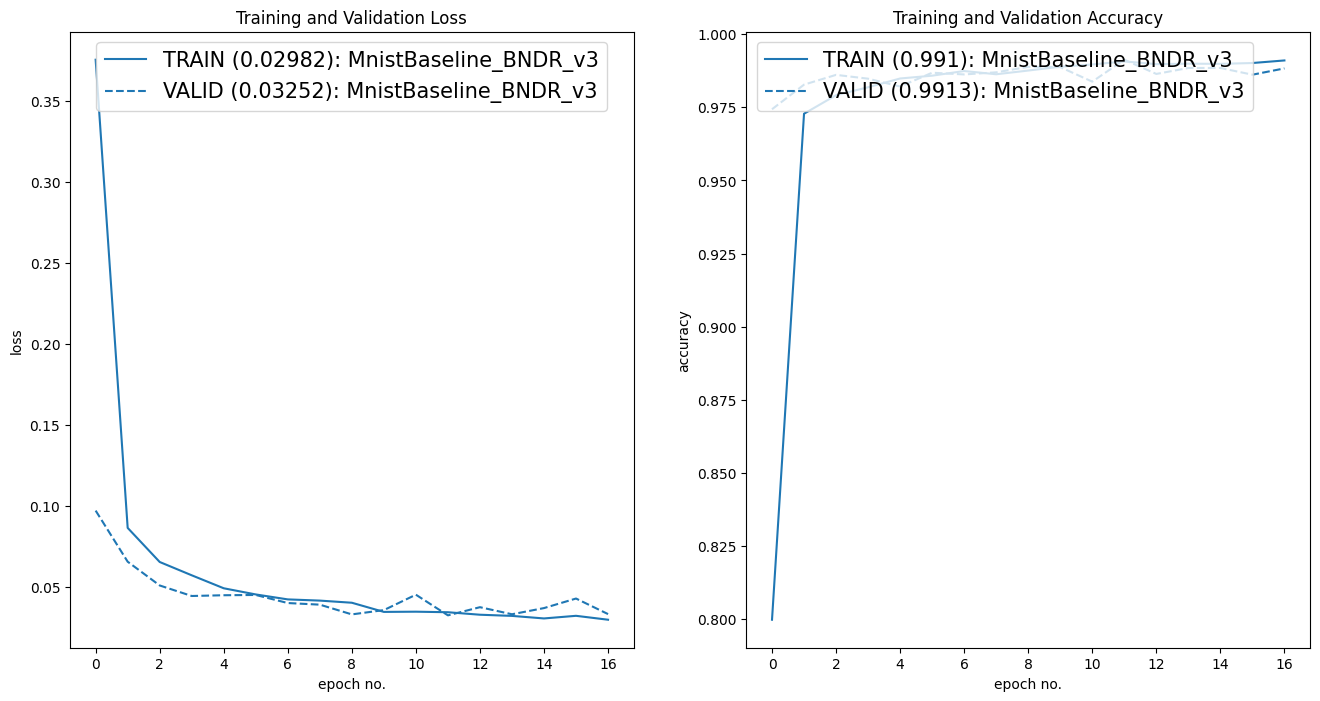

In [53]:
plot_loss_accuracy(train_loss= [train_losses],
                   val_loss= [test_losses],
                   train_acc= [train_metrics],
                   val_acc= [test_metrics],
                   labels=['MnistBaseline_BNDR_v3'],
                   colors=['blue'],
                   loss_legend_loc='upper center',
                   acc_legend_loc='upper left')

In [54]:
class MnistBaseline_BNDR_v4(nn.Module):
    """Feedfoward neural network with 2 Cnn blocks and 1 hidden layer and BN and DPR"""
    def __init__(self, in_channels, hidden_units, out_channels):
        super(MnistBaseline_BNDR_v4, self).__init__()
        # Input starts with (28,28)
        # each conv block is like [conv->relu->conv->relu->maxpool]

        self.block1 = nn.Sequential(
            nn.Conv2d(in_channels = in_channels,
                      out_channels = hidden_units,
                      kernel_size=(3,3),
                      stride=1,
                     padding=0), #(26,26,HDUN)
            nn.BatchNorm2d(hidden_units),
            nn.ReLU(),
            nn.Conv2d(in_channels = hidden_units,
                      out_channels= hidden_units,
                      kernel_size=(3,3),
                      stride=1,
                      padding=0
            ), #(24,24,HDUN)
            nn.BatchNorm2d(hidden_units),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,2),
                         stride=(2,2)), #(12,12,HDUN)

            nn.Dropout(p=0.1)
        )

        self.block2 = nn.Sequential(
            nn.Conv2d(in_channels = hidden_units,
                      out_channels = hidden_units,
                      kernel_size=(3,3),
                      stride=1,
                      padding=0), #(10,10,HDUN)
            nn.BatchNorm2d(hidden_units),
            nn.ReLU(),
            nn.Conv2d(in_channels = hidden_units,
                      out_channels =hidden_units,
                      kernel_size=(3,3),
                      stride=1,
                      padding=0), #(8,8,HDUN)
            nn.BatchNorm2d(hidden_units),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,2),
                         stride=(2,2)), #(4,4,HDUN)

            nn.Dropout(p=0.1)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(4*4*hidden_units, out_channels*10),
            nn.BatchNorm1d(out_channels*10),
            nn.ReLU(),
            nn.Dropout(p=0.1),
            nn.Linear(out_channels*10, out_channels*5),
            nn.BatchNorm1d(out_channels*5),
            nn.ReLU(),
            nn.Linear(out_channels*5, out_channels)
        )

    def forward(self, x):
      """Forward propagation"""
      x = self.block1(x)
      x = self.block2(x)
      x = self.classifier(x)

      return x

In [55]:
# New Model Instance
normalized_model_v4 = MnistBaseline_BNDR_v4(in_channels=1,
                                           hidden_units=8,
                                           out_channels=10).to(device)
summary(normalized_model_v4, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              80
       BatchNorm2d-2            [-1, 8, 26, 26]              16
              ReLU-3            [-1, 8, 26, 26]               0
            Conv2d-4            [-1, 8, 24, 24]             584
       BatchNorm2d-5            [-1, 8, 24, 24]              16
              ReLU-6            [-1, 8, 24, 24]               0
         MaxPool2d-7            [-1, 8, 12, 12]               0
           Dropout-8            [-1, 8, 12, 12]               0
            Conv2d-9            [-1, 8, 10, 10]             584
      BatchNorm2d-10            [-1, 8, 10, 10]              16
             ReLU-11            [-1, 8, 10, 10]               0
           Conv2d-12              [-1, 8, 8, 8]             584
      BatchNorm2d-13              [-1, 8, 8, 8]              16
             ReLU-14              [-1, 

In [56]:
# driver setup----
# optmizer
optimizer = optim.Adam(normalized_model_v4.parameters(), lr=lr)
# loss
criterion = nn.CrossEntropyLoss()
# metric
metric = MulticlassAccuracy(device = device, num_classes=10)
# Early stopping
early_stopping = EarlyStopping(patience=5, verbose=True)

In [57]:
train_losses = []
train_metrics = []
test_losses = []
test_metrics = []

for epoch in range(0,epochs):
  print(f'Epoch {epoch}')
  train_losses, train_metrics = train_module(normalized_model_v4, device, train_loader, optimizer, criterion, metric, train_losses, train_metrics)
  test_losses , test_metrics = test_module(normalized_model_v4, device, test_loader, criterion, metric, test_losses, test_metrics)
  early_stopping(test_losses[-1], normalized_model_v4, epoch) # last recorded test loss to measure the improvement against the prior one
  if early_stopping.early_stop:
    print("Early stopping")
    break

Epoch 0


Avg Train Loss: 0.47004879256491977 Avg Train Metric: 0.7595812865157625: 100%|██████████| 469/469 [00:39<00:00, 11.82it/s]


Function Took 39.6896 seconds


Avg Test Loss: 0.09798959501181977 Avg Test Metric: 0.9721732132042511: 100%|██████████| 79/79 [00:06<00:00, 12.49it/s]


Function Took 6.3298 seconds
Validation loss decreased (inf --> 0.097990).  Saving model ...
Epoch 1


Avg Train Loss: 0.13111617158788608 Avg Train Metric: 0.958161979341812: 100%|██████████| 469/469 [00:39<00:00, 11.92it/s]


Function Took 39.3460 seconds


Avg Test Loss: 0.06063412633264744 Avg Test Metric: 0.980196900005582: 100%|██████████| 79/79 [00:06<00:00, 12.70it/s]


Function Took 6.2275 seconds
Validation loss decreased (0.097990 --> 0.060634).  Saving model ...
Epoch 2


Avg Train Loss: 0.104616128416585 Avg Train Metric: 0.9670486874671888: 100%|██████████| 469/469 [00:39<00:00, 12.00it/s]


Function Took 39.0929 seconds


Avg Test Loss: 0.04669350372992833 Avg Test Metric: 0.9852992130231254: 100%|██████████| 79/79 [00:06<00:00, 12.66it/s]


Function Took 6.2439 seconds
Validation loss decreased (0.060634 --> 0.046694).  Saving model ...
Epoch 3


Avg Train Loss: 0.08650896564594654 Avg Train Metric: 0.9716994431989787: 100%|██████████| 469/469 [00:39<00:00, 11.97it/s]


Function Took 39.1992 seconds


Avg Test Loss: 0.04195875273074342 Avg Test Metric: 0.9847718816769274: 100%|██████████| 79/79 [00:06<00:00, 13.01it/s]


Function Took 6.0799 seconds
Validation loss decreased (0.046694 --> 0.041959).  Saving model ...
Epoch 4


Avg Train Loss: 0.07764450749799387 Avg Train Metric: 0.9746392468399585: 100%|██████████| 469/469 [00:39<00:00, 11.95it/s]


Function Took 39.2644 seconds


Avg Test Loss: 0.042926887568982344 Avg Test Metric: 0.9876839375194115: 100%|██████████| 79/79 [00:06<00:00, 12.90it/s]


Function Took 6.1299 seconds
EarlyStopping counter: 1 out of 5
Epoch 5


Avg Train Loss: 0.07245074034229651 Avg Train Metric: 0.9769385847201479: 100%|██████████| 469/469 [00:39<00:00, 11.94it/s]


Function Took 39.2908 seconds


Avg Test Loss: 0.03598006112100203 Avg Test Metric: 0.987741881533514: 100%|██████████| 79/79 [00:06<00:00, 12.75it/s]


Function Took 6.2044 seconds
Validation loss decreased (0.041959 --> 0.035980).  Saving model ...
Epoch 6


Avg Train Loss: 0.06626301900799404 Avg Train Metric: 0.9791106336406553: 100%|██████████| 469/469 [00:38<00:00, 12.04it/s]


Function Took 38.9674 seconds


Avg Test Loss: 0.03898904521808123 Avg Test Metric: 0.9866794611834273: 100%|██████████| 79/79 [00:06<00:00, 12.68it/s]


Function Took 6.2378 seconds
EarlyStopping counter: 1 out of 5
Epoch 7


Avg Train Loss: 0.06512150215282878 Avg Train Metric: 0.9799804109245983: 100%|██████████| 469/469 [00:38<00:00, 12.09it/s]


Function Took 38.8091 seconds


Avg Test Loss: 0.034621924291588835 Avg Test Metric: 0.9887236915057218: 100%|██████████| 79/79 [00:05<00:00, 13.19it/s]


Function Took 5.9957 seconds
Validation loss decreased (0.035980 --> 0.034622).  Saving model ...
Epoch 8


Avg Train Loss: 0.06356774305881087 Avg Train Metric: 0.979292607637865: 100%|██████████| 469/469 [00:39<00:00, 11.90it/s]


Function Took 39.4142 seconds


Avg Test Loss: 0.03419001132568132 Avg Test Metric: 0.9883946104894711: 100%|██████████| 79/79 [00:06<00:00, 13.12it/s]


Function Took 6.0279 seconds
Validation loss decreased (0.034622 --> 0.034190).  Saving model ...
Epoch 9


Avg Train Loss: 0.056979002597839085 Avg Train Metric: 0.9821374655278252: 100%|██████████| 469/469 [00:38<00:00, 12.05it/s]


Function Took 38.9340 seconds


Avg Test Loss: 0.03471472076894833 Avg Test Metric: 0.989512999601002: 100%|██████████| 79/79 [00:06<00:00, 12.70it/s]


Function Took 6.2264 seconds
EarlyStopping counter: 1 out of 5
Epoch 10


Avg Train Loss: 0.05632544093743475 Avg Train Metric: 0.9816405975234026: 100%|██████████| 469/469 [00:38<00:00, 12.16it/s]


Function Took 38.5687 seconds


Avg Test Loss: 0.03470647953674669 Avg Test Metric: 0.9883863397791416: 100%|██████████| 79/79 [00:05<00:00, 13.30it/s]


Function Took 5.9480 seconds
EarlyStopping counter: 2 out of 5
Epoch 11


Avg Train Loss: 0.05576828422882695 Avg Train Metric: 0.98181832726322: 100%|██████████| 469/469 [00:38<00:00, 12.21it/s]


Function Took 38.4093 seconds


Avg Test Loss: 0.03111265982571942 Avg Test Metric: 0.9897607353669179: 100%|██████████| 79/79 [00:05<00:00, 13.38it/s]


Function Took 5.9091 seconds
Validation loss decreased (0.034190 --> 0.031113).  Saving model ...
Epoch 12


Avg Train Loss: 0.05531869388457491 Avg Train Metric: 0.980985744421416: 100%|██████████| 469/469 [00:38<00:00, 12.29it/s]


Function Took 38.1532 seconds


Avg Test Loss: 0.03331211745102383 Avg Test Metric: 0.9870746648764308: 100%|██████████| 79/79 [00:05<00:00, 13.35it/s]


Function Took 5.9256 seconds
EarlyStopping counter: 1 out of 5
Epoch 13


Avg Train Loss: 0.05333773112460685 Avg Train Metric: 0.983125363839969: 100%|██████████| 469/469 [00:37<00:00, 12.37it/s]


Function Took 37.9141 seconds


Avg Test Loss: 0.03031064383096144 Avg Test Metric: 0.9908616920060749: 100%|██████████| 79/79 [00:06<00:00, 13.02it/s]


Function Took 6.0743 seconds
Validation loss decreased (0.031113 --> 0.030311).  Saving model ...
Epoch 14


Avg Train Loss: 0.05456786250213046 Avg Train Metric: 0.9845157514757185: 100%|██████████| 469/469 [00:37<00:00, 12.49it/s]


Function Took 37.5574 seconds


Avg Test Loss: 0.02975413740223533 Avg Test Metric: 0.9905034288575377: 100%|██████████| 79/79 [00:05<00:00, 13.69it/s]


Function Took 5.7771 seconds
Validation loss decreased (0.030311 --> 0.029754).  Saving model ...
Epoch 15


Avg Train Loss: 0.05055672286956041 Avg Train Metric: 0.9844630110238407: 100%|██████████| 469/469 [00:37<00:00, 12.51it/s]


Function Took 37.4877 seconds


Avg Test Loss: 0.0291446207483193 Avg Test Metric: 0.9900796790666218: 100%|██████████| 79/79 [00:05<00:00, 13.49it/s]


Function Took 5.8591 seconds
Validation loss decreased (0.029754 --> 0.029145).  Saving model ...
Epoch 16


Avg Train Loss: 0.04854828838223238 Avg Train Metric: 0.9846389610121753: 100%|██████████| 469/469 [00:37<00:00, 12.36it/s]


Function Took 37.9477 seconds


Avg Test Loss: 0.02920678894837163 Avg Test Metric: 0.9909182892570013: 100%|██████████| 79/79 [00:05<00:00, 13.34it/s]


Function Took 5.9265 seconds
EarlyStopping counter: 1 out of 5
Epoch 17


Avg Train Loss: 0.05062724826887234 Avg Train Metric: 0.9830149396904496: 100%|██████████| 469/469 [00:37<00:00, 12.35it/s]


Function Took 37.9822 seconds


Avg Test Loss: 0.03150025481075237 Avg Test Metric: 0.9912437977670114: 100%|██████████| 79/79 [00:05<00:00, 13.48it/s]


Function Took 5.8638 seconds
EarlyStopping counter: 2 out of 5
Epoch 18


Avg Train Loss: 0.04878063222417223 Avg Train Metric: 0.9836227221529621: 100%|██████████| 469/469 [00:37<00:00, 12.46it/s]


Function Took 37.6561 seconds


Avg Test Loss: 0.029089057348709837 Avg Test Metric: 0.9891207670863671: 100%|██████████| 79/79 [00:05<00:00, 13.77it/s]


Function Took 5.7434 seconds
Validation loss decreased (0.029145 --> 0.029089).  Saving model ...
Epoch 19


Avg Train Loss: 0.04837540533147387 Avg Train Metric: 0.984357684405882: 100%|██████████| 469/469 [00:37<00:00, 12.51it/s]


Function Took 37.4972 seconds


Avg Test Loss: 0.03158132470937894 Avg Test Metric: 0.9893362220329575: 100%|██████████| 79/79 [00:05<00:00, 13.44it/s]

Function Took 5.8825 seconds
EarlyStopping counter: 1 out of 5


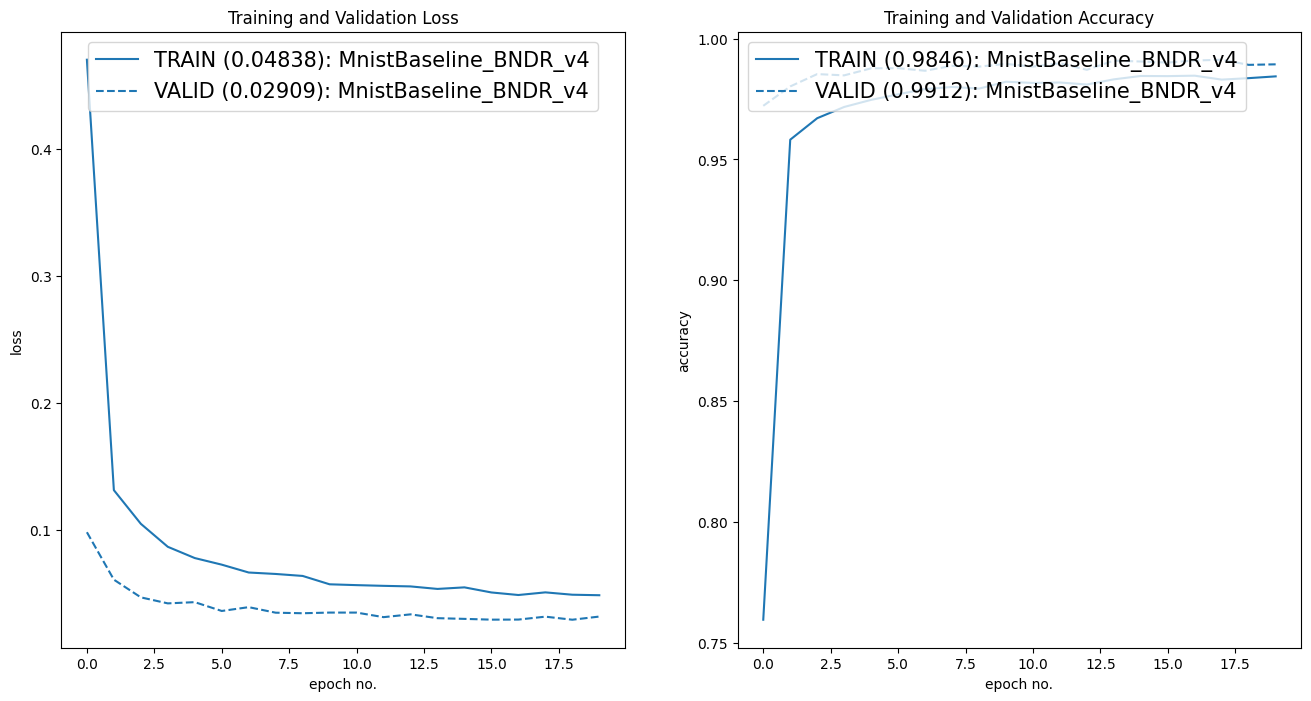

In [61]:
plot_loss_accuracy(train_loss= [train_losses],
                   val_loss= [test_losses],
                   train_acc= [train_metrics],
                   val_acc= [test_metrics],
                   labels=['MnistBaseline_BNDR_v4'],
                   colors=['blue'],
                   loss_legend_loc='upper center',
                   acc_legend_loc='upper left')

The best model so far is MnistBaseline_BNDR based on number of times validation accuracy has crossed the mark of 99%

### APPLICATION of Global Average Pooling

In [101]:
class MnistBaseline_BNDR_GAP(nn.Module):
    """Feedfoward neural network with 2 Cnn blocks and 1 hidden layer and BN and DPR"""
    def __init__(self, in_channels, hidden_units, out_channels):
        super(MnistBaseline_BNDR_GAP, self).__init__()
        # Input starts with (28,28)
        # each conv block is like [conv->relu->conv->relu->maxpool]

        self.block1 = nn.Sequential(
            nn.Conv2d(in_channels = in_channels,
                      out_channels = hidden_units,
                      kernel_size=(3,3),
                      stride=1,
                     padding=1),
            nn.BatchNorm2d(hidden_units),
            nn.ReLU(),
            nn.Conv2d(in_channels = hidden_units,
                      out_channels= hidden_units,
                      kernel_size=(3,3),
                      stride=1,
                      padding=1
            ),
            nn.BatchNorm2d(hidden_units),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,2),
                         stride=(2,2)),

            nn.Dropout(p=0.1)
        )

        self.block2 = nn.Sequential(
            nn.Conv2d(in_channels = hidden_units,
                      out_channels = hidden_units,
                      kernel_size=(3,3),
                      stride=1,
                      padding=1), #
            nn.BatchNorm2d(hidden_units),
            nn.ReLU(),
            nn.Conv2d(in_channels = hidden_units,
                      out_channels =hidden_units,
                      kernel_size=(3,3),
                      stride=1,
                      padding=1),
            nn.BatchNorm2d(hidden_units),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,2),
                         stride=(2,2)),

            nn.Dropout(p=0.1),

        )

        self.block3 = nn.Sequential(
            nn.Conv2d(in_channels = hidden_units,
                      out_channels = hidden_units,
                      kernel_size=(3,3),
                      stride=1,
                      padding=1),

            nn.BatchNorm2d(hidden_units),
            nn.ReLU(),
            nn.Conv2d(in_channels = hidden_units,
                      out_channels =hidden_units,
                      kernel_size=(3,3),
                      stride=1,
                      padding=1),
            nn.BatchNorm2d(hidden_units),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,2),
                         stride=(2,2))
        )


        self.gap = nn.Sequential(
            nn.AdaptiveAvgPool2d((1,1)) # op is HUDN
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(hidden_units, out_channels*10),
            nn.BatchNorm1d(out_channels*10),
            nn.ReLU(),
            nn.Linear(out_channels*10, out_channels*5),
            nn.BatchNorm1d(out_channels*5),
            nn.ReLU(),
            nn.Linear(out_channels*5, out_channels)
        )

    def forward(self, x):
      """Forward propagation"""
      x = self.block1(x)
      x = self.block2(x)
      x = self.block3(x)
      x = self.gap(x)
      x = self.classifier(x)

      return x

In [97]:
# New Model Instance
normalized_model_gap = MnistBaseline_BNDR_GAP(in_channels=1,
                                           hidden_units=16,
                                           out_channels=10).to(device)
summary(normalized_model_gap, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             160
       BatchNorm2d-2           [-1, 16, 28, 28]              32
              ReLU-3           [-1, 16, 28, 28]               0
            Conv2d-4           [-1, 16, 28, 28]           2,320
       BatchNorm2d-5           [-1, 16, 28, 28]              32
              ReLU-6           [-1, 16, 28, 28]               0
         MaxPool2d-7           [-1, 16, 14, 14]               0
           Dropout-8           [-1, 16, 14, 14]               0
            Conv2d-9           [-1, 16, 14, 14]           2,320
      BatchNorm2d-10           [-1, 16, 14, 14]              32
             ReLU-11           [-1, 16, 14, 14]               0
           Conv2d-12           [-1, 16, 14, 14]           2,320
      BatchNorm2d-13           [-1, 16, 14, 14]              32
             ReLU-14           [-1, 16,

In [98]:
# driver setup----
# optmizer
optimizer = optim.Adam(normalized_model_gap.parameters(), lr=lr)
# loss
criterion = nn.CrossEntropyLoss()
# metric
metric = MulticlassAccuracy(device = device, num_classes=10)
# Early stopping
early_stopping = EarlyStopping(patience=5, verbose=True)

In [99]:
train_losses = []
train_metrics = []
test_losses = []
test_metrics = []

for epoch in range(0,epochs):
  print(f'Epoch {epoch}')
  train_losses, train_metrics = train_module(normalized_model_gap, device, train_loader, optimizer, criterion, metric, train_losses, train_metrics)
  test_losses , test_metrics = test_module(normalized_model_gap, device, test_loader, criterion, metric, test_losses, test_metrics)
  early_stopping(test_losses[-1], normalized_model_gap, epoch) # last recorded test loss to measure the improvement against the prior one
  if early_stopping.early_stop:
    print("Early stopping")
    break

Epoch 0


Avg Train Loss: 0.41527285503108363 Avg Train Metric: 0.7449828117831684: 100%|██████████| 469/469 [00:40<00:00, 11.60it/s]


Function Took 40.4484 seconds


Avg Test Loss: 0.09281966920140423 Avg Test Metric: 0.9752747710747055: 100%|██████████| 79/79 [00:06<00:00, 12.61it/s]


Function Took 6.2695 seconds
Validation loss decreased (inf --> 0.092820).  Saving model ...
Epoch 1


Avg Train Loss: 0.10304502181327546 Avg Train Metric: 0.9664826995528328: 100%|██████████| 469/469 [00:40<00:00, 11.66it/s]


Function Took 40.2375 seconds


Avg Test Loss: 0.062494661659002304 Avg Test Metric: 0.9798551933674873: 100%|██████████| 79/79 [00:06<00:00, 11.98it/s]


Function Took 6.5990 seconds
Validation loss decreased (0.092820 --> 0.062495).  Saving model ...
Epoch 2


Avg Train Loss: 0.07834799559727343 Avg Train Metric: 0.9754214956562148: 100%|██████████| 469/469 [00:41<00:00, 11.19it/s]


Function Took 41.9291 seconds


Avg Test Loss: 0.04651604648797384 Avg Test Metric: 0.9835151169873491: 100%|██████████| 79/79 [00:06<00:00, 12.83it/s]


Function Took 6.1631 seconds
Validation loss decreased (0.062495 --> 0.046516).  Saving model ...
Epoch 3


Avg Train Loss: 0.06728294374210748 Avg Train Metric: 0.9795562202996536: 100%|██████████| 469/469 [00:40<00:00, 11.72it/s]


Function Took 40.0249 seconds


Avg Test Loss: 0.038534398426455035 Avg Test Metric: 0.9882772240457656: 100%|██████████| 79/79 [00:06<00:00, 12.47it/s]


Function Took 6.3428 seconds
Validation loss decreased (0.046516 --> 0.038534).  Saving model ...
Epoch 4


Avg Train Loss: 0.05974614517842688 Avg Train Metric: 0.9798415683225782: 100%|██████████| 469/469 [00:40<00:00, 11.69it/s]


Function Took 40.1157 seconds


Avg Test Loss: 0.03697496985049942 Avg Test Metric: 0.9882020278822018: 100%|██████████| 79/79 [00:06<00:00, 12.64it/s]


Function Took 6.2568 seconds
Validation loss decreased (0.038534 --> 0.036975).  Saving model ...
Epoch 5


Avg Train Loss: 0.0570214886589647 Avg Train Metric: 0.9831097476772154: 100%|██████████| 469/469 [00:39<00:00, 11.97it/s]


Function Took 39.1996 seconds


Avg Test Loss: 0.03886117291919698 Avg Test Metric: 0.9875639277168468: 100%|██████████| 79/79 [00:06<00:00, 12.84it/s]


Function Took 6.1563 seconds
EarlyStopping counter: 1 out of 5
Epoch 6


Avg Train Loss: 0.05312149087264975 Avg Train Metric: 0.9848008819226263: 100%|██████████| 469/469 [00:38<00:00, 12.07it/s]


Function Took 38.8635 seconds


Avg Test Loss: 0.03504614232555975 Avg Test Metric: 0.9882615072817742: 100%|██████████| 79/79 [00:06<00:00, 12.92it/s]


Function Took 6.1213 seconds
Validation loss decreased (0.036975 --> 0.035046).  Saving model ...
Epoch 7


Avg Train Loss: 0.051049065842692344 Avg Train Metric: 0.984700948444765: 100%|██████████| 469/469 [00:38<00:00, 12.09it/s]


Function Took 38.7838 seconds


Avg Test Loss: 0.03331865327833574 Avg Test Metric: 0.9888523160656796: 100%|██████████| 79/79 [00:06<00:00, 11.90it/s]


Function Took 6.6446 seconds
Validation loss decreased (0.035046 --> 0.033319).  Saving model ...
Epoch 8


Avg Train Loss: 0.048102073384814266 Avg Train Metric: 0.9844265066738576: 100%|██████████| 469/469 [00:41<00:00, 11.29it/s]


Function Took 41.5644 seconds


Avg Test Loss: 0.03533726070618516 Avg Test Metric: 0.989803333825703: 100%|██████████| 79/79 [00:05<00:00, 13.44it/s]


Function Took 5.8832 seconds
EarlyStopping counter: 1 out of 5
Epoch 9


Avg Train Loss: 0.047574114966899284 Avg Train Metric: 0.9855112313970066: 100%|██████████| 469/469 [00:38<00:00, 12.06it/s]


Function Took 38.8918 seconds


Avg Test Loss: 0.035834783417043055 Avg Test Metric: 0.9909793364850781: 100%|██████████| 79/79 [00:06<00:00, 13.13it/s]


Function Took 6.0230 seconds
EarlyStopping counter: 2 out of 5
Epoch 10


Avg Train Loss: 0.04327326009808573 Avg Train Metric: 0.9864808608219822: 100%|██████████| 469/469 [00:39<00:00, 11.95it/s]


Function Took 39.2545 seconds


Avg Test Loss: 0.03107635078574472 Avg Test Metric: 0.9882934093475342: 100%|██████████| 79/79 [00:06<00:00, 12.49it/s]


Function Took 6.3314 seconds
Validation loss decreased (0.033319 --> 0.031076).  Saving model ...
Epoch 11


Avg Train Loss: 0.0418405530012167 Avg Train Metric: 0.9864608417950205: 100%|██████████| 469/469 [00:40<00:00, 11.54it/s]


Function Took 40.6432 seconds


Avg Test Loss: 0.0296716686202614 Avg Test Metric: 0.9903525906273082: 100%|██████████| 79/79 [00:06<00:00, 12.63it/s]


Function Took 6.2643 seconds
Validation loss decreased (0.031076 --> 0.029672).  Saving model ...
Epoch 12


Avg Train Loss: 0.04305032496628508 Avg Train Metric: 0.986743896119376: 100%|██████████| 469/469 [00:40<00:00, 11.54it/s]


Function Took 40.6617 seconds


Avg Test Loss: 0.03078021467560195 Avg Test Metric: 0.9903982923000674: 100%|██████████| 79/79 [00:06<00:00, 12.38it/s]


Function Took 6.3897 seconds
EarlyStopping counter: 1 out of 5
Epoch 13


Avg Train Loss: 0.04000027930395785 Avg Train Metric: 0.9871271289487892: 100%|██████████| 469/469 [00:40<00:00, 11.61it/s]


Function Took 40.3886 seconds


Avg Test Loss: 0.030207739857060812 Avg Test Metric: 0.9908320617072189: 100%|██████████| 79/79 [00:06<00:00, 12.29it/s]


Function Took 6.4342 seconds
EarlyStopping counter: 2 out of 5
Epoch 14


Avg Train Loss: 0.03825546609116658 Avg Train Metric: 0.9875547696532471: 100%|██████████| 469/469 [00:40<00:00, 11.56it/s]


Function Took 40.5680 seconds


Avg Test Loss: 0.028307020671583145 Avg Test Metric: 0.9915372540679159: 100%|██████████| 79/79 [00:06<00:00, 11.71it/s]


Function Took 6.7530 seconds
Validation loss decreased (0.029672 --> 0.028307).  Saving model ...
Epoch 15


Avg Train Loss: 0.03948572042809208 Avg Train Metric: 0.9871795778589716: 100%|██████████| 469/469 [00:41<00:00, 11.30it/s]


Function Took 41.4988 seconds


Avg Test Loss: 0.029098886884513158 Avg Test Metric: 0.989920108378688: 100%|██████████| 79/79 [00:06<00:00, 12.24it/s]


Function Took 6.4619 seconds
EarlyStopping counter: 1 out of 5
Epoch 16


Avg Train Loss: 0.03791852979444221 Avg Train Metric: 0.9874653666258366: 100%|██████████| 469/469 [00:41<00:00, 11.39it/s]


Function Took 41.1902 seconds


Avg Test Loss: 0.02802560012345497 Avg Test Metric: 0.9903321356713017: 100%|██████████| 79/79 [00:06<00:00, 12.06it/s]


Function Took 6.5565 seconds
Validation loss decreased (0.028307 --> 0.028026).  Saving model ...
Epoch 17


Avg Train Loss: 0.038359409902365936 Avg Train Metric: 0.9878066044880637: 100%|██████████| 469/469 [00:40<00:00, 11.49it/s]


Function Took 40.8180 seconds


Avg Test Loss: 0.025782355468401897 Avg Test Metric: 0.9917713931844204: 100%|██████████| 79/79 [00:06<00:00, 12.61it/s]


Function Took 6.2736 seconds
Validation loss decreased (0.028026 --> 0.025782).  Saving model ...
Epoch 18


Avg Train Loss: 0.03569313616894964 Avg Train Metric: 0.9888257158082178: 100%|██████████| 469/469 [00:41<00:00, 11.39it/s]


Function Took 41.1979 seconds


Avg Test Loss: 0.03468423112460613 Avg Test Metric: 0.9906151604048813: 100%|██████████| 79/79 [00:06<00:00, 12.41it/s]


Function Took 6.3714 seconds
EarlyStopping counter: 1 out of 5
Epoch 19


Avg Train Loss: 0.03667286855589622 Avg Train Metric: 0.9887579927312286: 100%|██████████| 469/469 [00:40<00:00, 11.46it/s]


Function Took 40.9269 seconds


Avg Test Loss: 0.02328691878532873 Avg Test Metric: 0.9934509600265117: 100%|██████████| 79/79 [00:06<00:00, 12.32it/s]


Function Took 6.4193 seconds
Validation loss decreased (0.025782 --> 0.023287).  Saving model ...


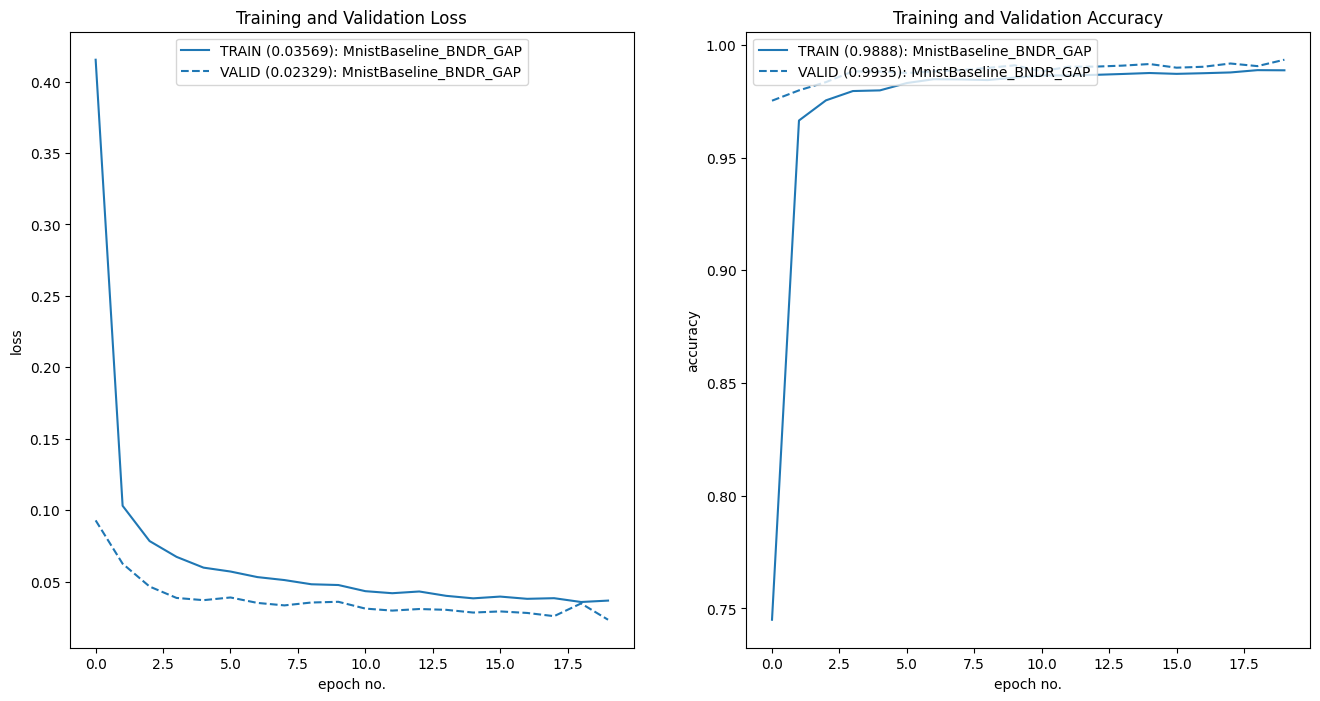

In [100]:
plot_loss_accuracy(train_loss= [train_losses],
                   val_loss= [test_losses],
                   train_acc= [train_metrics],
                   val_acc= [test_metrics],
                   labels=['MnistBaseline_BNDR_GAP'],
                   colors=['blue'],
                   loss_legend_loc='upper center',
                   acc_legend_loc='upper left')

 better last best model MnistBaseline_BNDR
so Finally we select both of these models for next round with Gap one best and BNDR second best

### Application of Adaptive LR variants on above best

#### First lets try the best model till now with lr =1e-2

In [105]:
# New Model Instance
best_model1 = MnistBaseline_BNDR_GAP(in_channels=1,
                                           hidden_units=16,
                                           out_channels=10).to(device)
summary(normalized_model_gap, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             160
       BatchNorm2d-2           [-1, 16, 28, 28]              32
              ReLU-3           [-1, 16, 28, 28]               0
            Conv2d-4           [-1, 16, 28, 28]           2,320
       BatchNorm2d-5           [-1, 16, 28, 28]              32
              ReLU-6           [-1, 16, 28, 28]               0
         MaxPool2d-7           [-1, 16, 14, 14]               0
           Dropout-8           [-1, 16, 14, 14]               0
            Conv2d-9           [-1, 16, 14, 14]           2,320
      BatchNorm2d-10           [-1, 16, 14, 14]              32
             ReLU-11           [-1, 16, 14, 14]               0
           Conv2d-12           [-1, 16, 14, 14]           2,320
      BatchNorm2d-13           [-1, 16, 14, 14]              32
             ReLU-14           [-1, 16,

In [106]:
# driver setup----
# optmizer
optimizer = optim.Adam(best_model1.parameters(), lr=1e-2)
# loss
criterion = nn.CrossEntropyLoss()
# metric
metric = MulticlassAccuracy(device = device, num_classes=10)
# Early stopping
early_stopping = EarlyStopping(patience=5, verbose=True)

In [107]:
train_losses = []
train_metrics = []
test_losses = []
test_metrics = []

for epoch in range(0,epochs):
  print(f'Epoch {epoch}')
  train_losses, train_metrics = train_module(best_model1, device, train_loader, optimizer, criterion, metric, train_losses, train_metrics)
  test_losses , test_metrics = test_module(best_model1, device, test_loader, criterion, metric, test_losses, test_metrics)
  early_stopping(test_losses[-1], best_model1, epoch) # last recorded test loss to measure the improvement against the prior one
  if early_stopping.early_stop:
    print("Early stopping")
    break

Epoch 0


Avg Train Loss: 0.23799525378450656 Avg Train Metric: 0.8476498070111407: 100%|██████████| 469/469 [00:39<00:00, 11.79it/s]


Function Took 39.7692 seconds


Avg Test Loss: 0.16013854350658913 Avg Test Metric: 0.9488080988956403: 100%|██████████| 79/79 [00:06<00:00, 12.45it/s]


Function Took 6.3503 seconds
Validation loss decreased (inf --> 0.160139).  Saving model ...
Epoch 1


Avg Train Loss: 0.09907832846188469 Avg Train Metric: 0.9659929367016628: 100%|██████████| 469/469 [00:39<00:00, 11.81it/s]


Function Took 39.7063 seconds


Avg Test Loss: 0.12135649939315228 Avg Test Metric: 0.965219298495522: 100%|██████████| 79/79 [00:06<00:00, 12.30it/s]


Function Took 6.4324 seconds
Validation loss decreased (0.160139 --> 0.121356).  Saving model ...
Epoch 2


Avg Train Loss: 0.08633858453371186 Avg Train Metric: 0.9716975957091684: 100%|██████████| 469/469 [00:40<00:00, 11.59it/s]


Function Took 40.4572 seconds


Avg Test Loss: 0.057668246871119815 Avg Test Metric: 0.9827354806887952: 100%|██████████| 79/79 [00:06<00:00, 12.40it/s]


Function Took 6.3794 seconds
Validation loss decreased (0.121356 --> 0.057668).  Saving model ...
Epoch 3


Avg Train Loss: 0.07176179766380933 Avg Train Metric: 0.9775089934182319: 100%|██████████| 469/469 [00:40<00:00, 11.62it/s]


Function Took 40.3554 seconds


Avg Test Loss: 0.05644310726356822 Avg Test Metric: 0.9833236215989801: 100%|██████████| 79/79 [00:06<00:00, 12.43it/s]


Function Took 6.3600 seconds
Validation loss decreased (0.057668 --> 0.056443).  Saving model ...
Epoch 4


Avg Train Loss: 0.06690727728706941 Avg Train Metric: 0.9794765062677835: 100%|██████████| 469/469 [00:40<00:00, 11.63it/s]


Function Took 40.3191 seconds


Avg Test Loss: 0.06569652809891142 Avg Test Metric: 0.9810179049455667: 100%|██████████| 79/79 [00:06<00:00, 12.55it/s]


Function Took 6.3000 seconds
EarlyStopping counter: 1 out of 5
Epoch 5


Avg Train Loss: 0.06314928991360658 Avg Train Metric: 0.9817956720333872: 100%|██████████| 469/469 [00:40<00:00, 11.71it/s]


Function Took 40.0727 seconds


Avg Test Loss: 0.04128128377414202 Avg Test Metric: 0.9855254669732685: 100%|██████████| 79/79 [00:06<00:00, 12.62it/s]


Function Took 6.2676 seconds
Validation loss decreased (0.056443 --> 0.041281).  Saving model ...
Epoch 6


Avg Train Loss: 0.058518713807810284 Avg Train Metric: 0.9826234206716135: 100%|██████████| 469/469 [00:39<00:00, 11.78it/s]


Function Took 39.8228 seconds


Avg Test Loss: 0.04067650172989108 Avg Test Metric: 0.9868189398246475: 100%|██████████| 79/79 [00:05<00:00, 13.40it/s]


Function Took 5.9042 seconds
Validation loss decreased (0.041281 --> 0.040677).  Saving model ...
Epoch 7


Avg Train Loss: 0.05577439922285375 Avg Train Metric: 0.9828908886990821: 100%|██████████| 469/469 [00:38<00:00, 12.05it/s]


Function Took 38.9220 seconds


Avg Test Loss: 0.03635898308793106 Avg Test Metric: 0.9879410938371586: 100%|██████████| 79/79 [00:06<00:00, 12.42it/s]


Function Took 6.3666 seconds
Validation loss decreased (0.040677 --> 0.036359).  Saving model ...
Epoch 8


Avg Train Loss: 0.05469543474348091 Avg Train Metric: 0.9826426800888485: 100%|██████████| 469/469 [00:38<00:00, 12.13it/s]


Function Took 38.6627 seconds


Avg Test Loss: 0.04011880048208787 Avg Test Metric: 0.9878620030004767: 100%|██████████| 79/79 [00:06<00:00, 12.82it/s]


Function Took 6.1677 seconds
EarlyStopping counter: 1 out of 5
Epoch 9


Avg Train Loss: 0.05380288563938791 Avg Train Metric: 0.9829546192815817: 100%|██████████| 469/469 [00:38<00:00, 12.30it/s]


Function Took 38.1415 seconds


Avg Test Loss: 0.04616965668547097 Avg Test Metric: 0.9884954117521455: 100%|██████████| 79/79 [00:05<00:00, 13.32it/s]


Function Took 5.9357 seconds
EarlyStopping counter: 2 out of 5
Epoch 10


Avg Train Loss: 0.050808663812350795 Avg Train Metric: 0.9851756466985512: 100%|██████████| 469/469 [00:38<00:00, 12.16it/s]


Function Took 38.5853 seconds


Avg Test Loss: 0.056260000218790546 Avg Test Metric: 0.9838231334203407: 100%|██████████| 79/79 [00:05<00:00, 13.20it/s]


Function Took 5.9899 seconds
EarlyStopping counter: 3 out of 5
Epoch 11


Avg Train Loss: 0.050436537986847635 Avg Train Metric: 0.9848192199460988: 100%|██████████| 469/469 [00:39<00:00, 11.95it/s]


Function Took 39.2391 seconds


Avg Test Loss: 0.0399129374329991 Avg Test Metric: 0.9859706080412562: 100%|██████████| 79/79 [00:06<00:00, 12.52it/s]


Function Took 6.3152 seconds
EarlyStopping counter: 4 out of 5
Epoch 12


Avg Train Loss: 0.047689031360786095 Avg Train Metric: 0.9837420652670138: 100%|██████████| 469/469 [00:39<00:00, 11.87it/s]


Function Took 39.5037 seconds


Avg Test Loss: 0.03609573865262202 Avg Test Metric: 0.989160738413847: 100%|██████████| 79/79 [00:06<00:00, 13.04it/s]


Function Took 6.0630 seconds
Validation loss decreased (0.036359 --> 0.036096).  Saving model ...
Epoch 13


Avg Train Loss: 0.0451927411122752 Avg Train Metric: 0.9867893909848829: 100%|██████████| 469/469 [00:38<00:00, 12.10it/s]


Function Took 38.7674 seconds


Avg Test Loss: 0.03137941861560545 Avg Test Metric: 0.9894666981093491: 100%|██████████| 79/79 [00:05<00:00, 13.17it/s]


Function Took 6.0050 seconds
Validation loss decreased (0.036096 --> 0.031379).  Saving model ...
Epoch 14


Avg Train Loss: 0.04655961924319916 Avg Train Metric: 0.9861099031179953: 100%|██████████| 469/469 [00:38<00:00, 12.07it/s]


Function Took 38.8508 seconds


Avg Test Loss: 0.03304744980893322 Avg Test Metric: 0.9892332289792314: 100%|██████████| 79/79 [00:06<00:00, 13.00it/s]


Function Took 6.0838 seconds
EarlyStopping counter: 1 out of 5
Epoch 15


Avg Train Loss: 0.04509798738944616 Avg Train Metric: 0.9846288462691724: 100%|██████████| 469/469 [00:39<00:00, 11.81it/s]


Function Took 39.7054 seconds


Avg Test Loss: 0.030821980475271238 Avg Test Metric: 0.9892013533205926: 100%|██████████| 79/79 [00:06<00:00, 11.82it/s]


Function Took 6.6920 seconds
Validation loss decreased (0.031379 --> 0.030822).  Saving model ...
Epoch 16


Avg Train Loss: 0.04317415224513345 Avg Train Metric: 0.9864281869646329: 100%|██████████| 469/469 [00:39<00:00, 11.78it/s]


Function Took 39.8252 seconds


Avg Test Loss: 0.036581087120678986 Avg Test Metric: 0.9887335587151443: 100%|██████████| 79/79 [00:06<00:00, 12.57it/s]


Function Took 6.2911 seconds
EarlyStopping counter: 1 out of 5
Epoch 17


Avg Train Loss: 0.0395289425661704 Avg Train Metric: 0.9871993904937305: 100%|██████████| 469/469 [00:39<00:00, 11.80it/s]


Function Took 39.7677 seconds


Avg Test Loss: 0.03121681374724648 Avg Test Metric: 0.9918604425237149: 100%|██████████| 79/79 [00:06<00:00, 12.74it/s]


Function Took 6.2081 seconds
EarlyStopping counter: 2 out of 5
Epoch 18


Avg Train Loss: 0.0423424243646513 Avg Train Metric: 0.986572913523676: 100%|██████████| 469/469 [00:40<00:00, 11.67it/s]


Function Took 40.1788 seconds


Avg Test Loss: 0.04712989307716017 Avg Test Metric: 0.9883449009702175: 100%|██████████| 79/79 [00:06<00:00, 12.47it/s]


Function Took 6.3408 seconds
EarlyStopping counter: 3 out of 5
Epoch 19


Avg Train Loss: 0.040975891419056894 Avg Train Metric: 0.9873554080025728: 100%|██████████| 469/469 [00:39<00:00, 11.86it/s]


Function Took 39.5403 seconds


Avg Test Loss: 0.031246731567632736 Avg Test Metric: 0.9884743064264708: 100%|██████████| 79/79 [00:06<00:00, 12.70it/s]

Function Took 6.2287 seconds
EarlyStopping counter: 4 out of 5


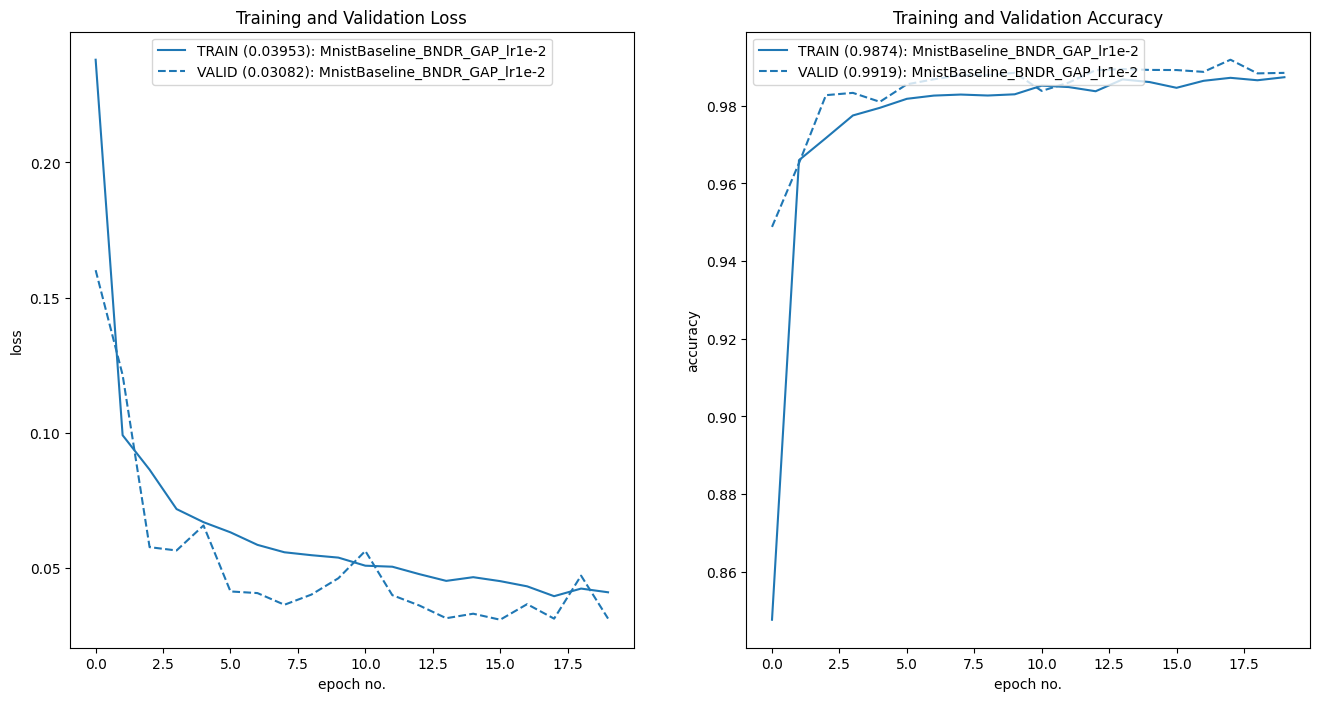

In [108]:
plot_loss_accuracy(train_loss= [train_losses],
                   val_loss= [test_losses],
                   train_acc= [train_metrics],
                   val_acc= [test_metrics],
                   labels=['MnistBaseline_BNDR_GAP_lr1e-2'],
                   colors=['blue'],
                   loss_legend_loc='upper center',
                   acc_legend_loc='upper left')

#### Exponential LR Scheduler

In [113]:
# New Model Instance
best_model1 = MnistBaseline_BNDR_GAP(in_channels=1,
                                           hidden_units=16,
                                           out_channels=10).to(device)
summary(normalized_model_gap, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             160
       BatchNorm2d-2           [-1, 16, 28, 28]              32
              ReLU-3           [-1, 16, 28, 28]               0
            Conv2d-4           [-1, 16, 28, 28]           2,320
       BatchNorm2d-5           [-1, 16, 28, 28]              32
              ReLU-6           [-1, 16, 28, 28]               0
         MaxPool2d-7           [-1, 16, 14, 14]               0
           Dropout-8           [-1, 16, 14, 14]               0
            Conv2d-9           [-1, 16, 14, 14]           2,320
      BatchNorm2d-10           [-1, 16, 14, 14]              32
             ReLU-11           [-1, 16, 14, 14]               0
           Conv2d-12           [-1, 16, 14, 14]           2,320
      BatchNorm2d-13           [-1, 16, 14, 14]              32
             ReLU-14           [-1, 16,

In [114]:
# driver setup----
# optmizer
optimizer = optim.Adam(best_model1.parameters(), lr=1e-2)
# loss
criterion = nn.CrossEntropyLoss()
# metric
metric = MulticlassAccuracy(device = device, num_classes=10)
# Early stopping
early_stopping = EarlyStopping(patience=5, verbose=True)

# LR Scheduler - Exponential
lr_scheduler = ExponentialLR(optimizer,gamma = 0.5) # lr_t = lr_t-1 * gamma

In [115]:
train_losses = []
train_metrics = []
test_losses = []
test_metrics = []

for epoch in range(0,epochs):
  print(f'Epoch {epoch}')
  train_losses, train_metrics = train_module(best_model1, device, train_loader, optimizer, criterion, metric, train_losses, train_metrics)
  test_losses , test_metrics = test_module(best_model1, device, test_loader, criterion, metric, test_losses, test_metrics)
  lr_scheduler.step() # lr scheduler stepping
  print(f"For next epoch {lr_scheduler.get_last_lr()[0]}")
  early_stopping(test_losses[-1], best_model1, epoch) # last recorded test loss to measure the improvement against the prior one
  if early_stopping.early_stop:
    print("Early stopping")
    break

Epoch 0


Avg Train Loss: 0.2454902434439611 Avg Train Metric: 0.830355115091877: 100%|██████████| 469/469 [00:40<00:00, 11.72it/s]


Function Took 40.0322 seconds


Avg Test Loss: 0.09974229028684241 Avg Test Metric: 0.9683109378512902: 100%|██████████| 79/79 [00:06<00:00, 12.37it/s]


Function Took 6.3932 seconds
For next epoch 0.005
Validation loss decreased (inf --> 0.099742).  Saving model ...
Epoch 1


Avg Train Loss: 0.0797196075177269 Avg Train Metric: 0.9746011142283361: 100%|██████████| 469/469 [00:39<00:00, 11.83it/s]


Function Took 39.6613 seconds


Avg Test Loss: 0.06160361240794764 Avg Test Metric: 0.9806437281113637: 100%|██████████| 79/79 [00:06<00:00, 12.54it/s]


Function Took 6.3051 seconds
For next epoch 0.0025
Validation loss decreased (0.099742 --> 0.061604).  Saving model ...
Epoch 2


Avg Train Loss: 0.05843458059571509 Avg Train Metric: 0.9815485529553916: 100%|██████████| 469/469 [00:40<00:00, 11.69it/s]


Function Took 40.1142 seconds


Avg Test Loss: 0.03733708097045369 Avg Test Metric: 0.9868791782403294: 100%|██████████| 79/79 [00:06<00:00, 12.46it/s]


Function Took 6.3449 seconds
For next epoch 0.00125
Validation loss decreased (0.061604 --> 0.037337).  Saving model ...
Epoch 3


Avg Train Loss: 0.04829460072384746 Avg Train Metric: 0.9842307884047534: 100%|██████████| 469/469 [00:39<00:00, 11.75it/s]


Function Took 39.9266 seconds


Avg Test Loss: 0.029857960343950347 Avg Test Metric: 0.9922917538051363: 100%|██████████| 79/79 [00:06<00:00, 12.72it/s]


Function Took 6.2140 seconds
For next epoch 0.000625
Validation loss decreased (0.037337 --> 0.029858).  Saving model ...
Epoch 4


Avg Train Loss: 0.04445919319331995 Avg Train Metric: 0.9855186960844597: 100%|██████████| 469/469 [00:40<00:00, 11.53it/s]


Function Took 40.6978 seconds


Avg Test Loss: 0.029243289663963303 Avg Test Metric: 0.9913846329797672: 100%|██████████| 79/79 [00:06<00:00, 12.36it/s]


Function Took 6.3953 seconds
For next epoch 0.0003125
Validation loss decreased (0.029858 --> 0.029243).  Saving model ...
Epoch 5


Avg Train Loss: 0.04177138030525051 Avg Train Metric: 0.9876930919537412: 100%|██████████| 469/469 [00:39<00:00, 11.97it/s]


Function Took 39.1968 seconds


Avg Test Loss: 0.028033424974890732 Avg Test Metric: 0.9903820240044896: 100%|██████████| 79/79 [00:06<00:00, 13.07it/s]


Function Took 6.0510 seconds
For next epoch 0.00015625
Validation loss decreased (0.029243 --> 0.028033).  Saving model ...
Epoch 6


Avg Train Loss: 0.03877278171412186 Avg Train Metric: 0.987706052469038: 100%|██████████| 469/469 [00:38<00:00, 12.28it/s]


Function Took 38.1945 seconds


Avg Test Loss: 0.024450716849923417 Avg Test Metric: 0.9914832333975201: 100%|██████████| 79/79 [00:06<00:00, 13.03it/s]


Function Took 6.0687 seconds
For next epoch 7.8125e-05
Validation loss decreased (0.028033 --> 0.024451).  Saving model ...
Epoch 7


Avg Train Loss: 0.03845940349148964 Avg Train Metric: 0.9880965387643273: 100%|██████████| 469/469 [00:39<00:00, 12.02it/s]


Function Took 39.0267 seconds


Avg Test Loss: 0.022759378224587703 Avg Test Metric: 0.9931177112120616: 100%|██████████| 79/79 [00:05<00:00, 13.43it/s]


Function Took 5.8879 seconds
For next epoch 3.90625e-05
Validation loss decreased (0.024451 --> 0.022759).  Saving model ...
Epoch 8


Avg Train Loss: 0.0374286655703488 Avg Train Metric: 0.9882875564001771: 100%|██████████| 469/469 [00:38<00:00, 12.17it/s]


Function Took 38.5526 seconds


Avg Test Loss: 0.026909118966211246 Avg Test Metric: 0.9918139999425863: 100%|██████████| 79/79 [00:05<00:00, 13.37it/s]


Function Took 5.9129 seconds
For next epoch 1.953125e-05
EarlyStopping counter: 1 out of 5
Epoch 9


Avg Train Loss: 0.037235959898184005 Avg Train Metric: 0.9885025002808967: 100%|██████████| 469/469 [00:38<00:00, 12.06it/s]


Function Took 38.9094 seconds


Avg Test Loss: 0.0263708339668103 Avg Test Metric: 0.9918925234034092: 100%|██████████| 79/79 [00:06<00:00, 12.88it/s]


Function Took 6.1420 seconds
For next epoch 9.765625e-06
EarlyStopping counter: 2 out of 5
Epoch 10


Avg Train Loss: 0.036936118877602064 Avg Train Metric: 0.9874376559308343: 100%|██████████| 469/469 [00:38<00:00, 12.14it/s]


Function Took 38.6327 seconds


Avg Test Loss: 0.02830833143884717 Avg Test Metric: 0.9912822299365756: 100%|██████████| 79/79 [00:06<00:00, 12.80it/s]


Function Took 6.1785 seconds
For next epoch 4.8828125e-06
EarlyStopping counter: 3 out of 5
Epoch 11


Avg Train Loss: 0.03939399462782029 Avg Train Metric: 0.9884691722611628: 100%|██████████| 469/469 [00:39<00:00, 11.77it/s]


Function Took 39.8542 seconds


Avg Test Loss: 0.02599065407338446 Avg Test Metric: 0.992606789250917: 100%|██████████| 79/79 [00:06<00:00, 12.86it/s]


Function Took 6.1484 seconds
For next epoch 2.44140625e-06
EarlyStopping counter: 4 out of 5
Epoch 12


Avg Train Loss: 0.037278217561880565 Avg Train Metric: 0.9885775154587556: 100%|██████████| 469/469 [00:39<00:00, 11.79it/s]


Function Took 39.7797 seconds


Avg Test Loss: 0.02379776819467639 Avg Test Metric: 0.9924002870728698: 100%|██████████| 79/79 [00:05<00:00, 13.23it/s]

Function Took 5.9772 seconds
For next epoch 1.220703125e-06
EarlyStopping counter: 5 out of 5
Early stopping


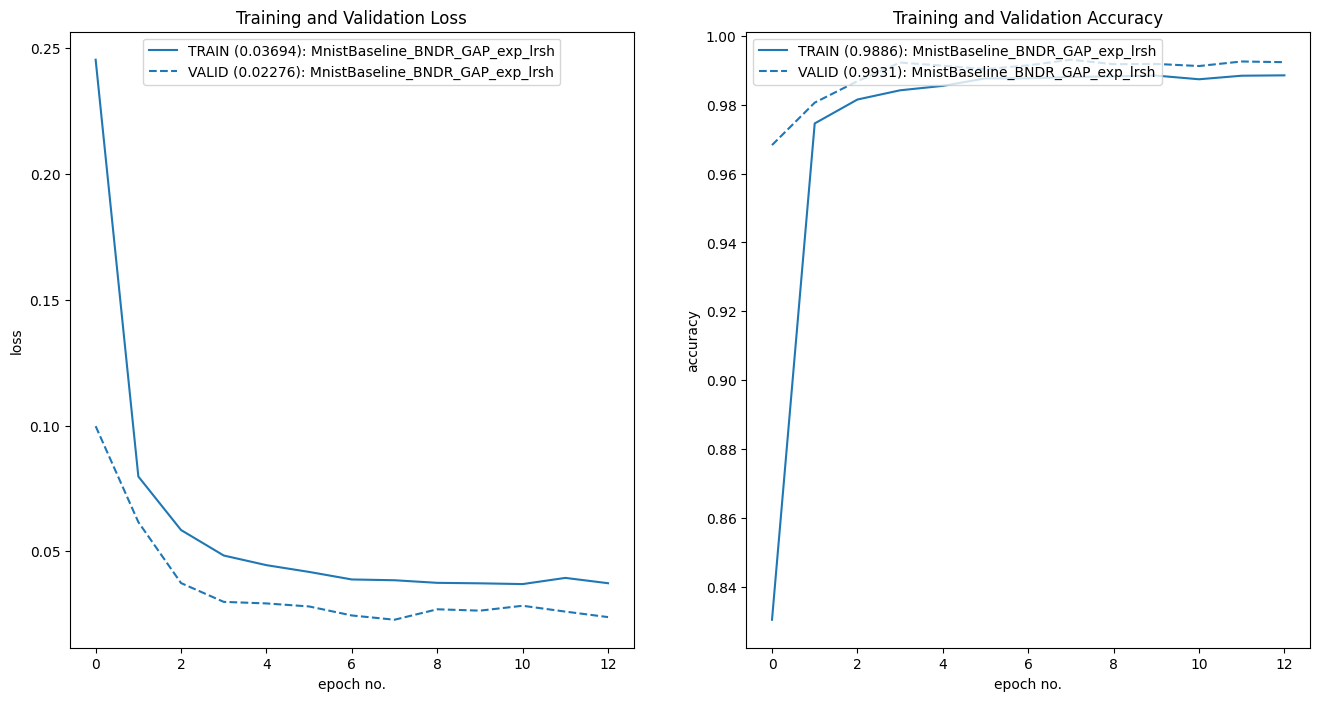

In [116]:
plot_loss_accuracy(train_loss= [train_losses],
                   val_loss= [test_losses],
                   train_acc= [train_metrics],
                   val_acc= [test_metrics],
                   labels=['MnistBaseline_BNDR_GAP_exp_lrsh'],
                   colors=['blue'],
                   loss_legend_loc='upper center',
                   acc_legend_loc='upper left')

In [117]:
# New Model Instance
best_model1 = MnistBaseline_BNDR_GAP(in_channels=1,
                                           hidden_units=16,
                                           out_channels=10).to(device)
summary(normalized_model_gap, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             160
       BatchNorm2d-2           [-1, 16, 28, 28]              32
              ReLU-3           [-1, 16, 28, 28]               0
            Conv2d-4           [-1, 16, 28, 28]           2,320
       BatchNorm2d-5           [-1, 16, 28, 28]              32
              ReLU-6           [-1, 16, 28, 28]               0
         MaxPool2d-7           [-1, 16, 14, 14]               0
           Dropout-8           [-1, 16, 14, 14]               0
            Conv2d-9           [-1, 16, 14, 14]           2,320
      BatchNorm2d-10           [-1, 16, 14, 14]              32
             ReLU-11           [-1, 16, 14, 14]               0
           Conv2d-12           [-1, 16, 14, 14]           2,320
      BatchNorm2d-13           [-1, 16, 14, 14]              32
             ReLU-14           [-1, 16,

In [118]:
# driver setup----
# optmizer
optimizer = optim.Adam(best_model1.parameters(), lr=1e-2)
# loss
criterion = nn.CrossEntropyLoss()
# metric
metric = MulticlassAccuracy(device = device, num_classes=10)
# Early stopping
early_stopping = EarlyStopping(patience=5, verbose=True)

# LR Scheduler - Exponential
lr_scheduler = ExponentialLR(optimizer,gamma = 0.8) # lr_t = lr_t-1 * gamma

In [119]:
train_losses = []
train_metrics = []
test_losses = []
test_metrics = []

for epoch in range(0,epochs):
  print(f'Epoch {epoch}')
  train_losses, train_metrics = train_module(best_model1, device, train_loader, optimizer, criterion, metric, train_losses, train_metrics)
  test_losses , test_metrics = test_module(best_model1, device, test_loader, criterion, metric, test_losses, test_metrics)
  lr_scheduler.step() # lr scheduler stepping
  print(f"For next epoch {lr_scheduler.get_last_lr()[0]}")
  early_stopping(test_losses[-1], best_model1, epoch) # last recorded test loss to measure the improvement against the prior one
  if early_stopping.early_stop:
    print("Early stopping")
    break

Epoch 0


Avg Train Loss: 0.23542496218864342 Avg Train Metric: 0.8441754072142054: 100%|██████████| 469/469 [00:38<00:00, 12.17it/s]


Function Took 38.5406 seconds


Avg Test Loss: 0.1297143932573403 Avg Test Metric: 0.9566897908343545: 100%|██████████| 79/79 [00:06<00:00, 12.97it/s]


Function Took 6.0944 seconds
For next epoch 0.008
Validation loss decreased (inf --> 0.129714).  Saving model ...
Epoch 1


Avg Train Loss: 0.08698037772604239 Avg Train Metric: 0.9724281163357976: 100%|██████████| 469/469 [00:39<00:00, 11.83it/s]


Function Took 39.6572 seconds


Avg Test Loss: 0.06443128680008688 Avg Test Metric: 0.9795248417914668: 100%|██████████| 79/79 [00:06<00:00, 12.79it/s]


Function Took 6.1793 seconds
For next epoch 0.0064
Validation loss decreased (0.129714 --> 0.064431).  Saving model ...
Epoch 2


Avg Train Loss: 0.06849864748433661 Avg Train Metric: 0.9778911703939377: 100%|██████████| 469/469 [00:39<00:00, 11.98it/s]


Function Took 39.1571 seconds


Avg Test Loss: 0.040241305215307804 Avg Test Metric: 0.986105545412136: 100%|██████████| 79/79 [00:06<00:00, 12.74it/s]


Function Took 6.2078 seconds
For next epoch 0.00512
Validation loss decreased (0.064431 --> 0.040241).  Saving model ...
Epoch 3


Avg Train Loss: 0.05869511470867833 Avg Train Metric: 0.9828117094568606: 100%|██████████| 469/469 [00:38<00:00, 12.11it/s]


Function Took 38.7248 seconds


Avg Test Loss: 0.04043355935748336 Avg Test Metric: 0.9854052843926828: 100%|██████████| 79/79 [00:06<00:00, 12.97it/s]


Function Took 6.0944 seconds
For next epoch 0.004096000000000001
EarlyStopping counter: 1 out of 5
Epoch 4


Avg Train Loss: 0.04977935098056028 Avg Train Metric: 0.9853479700810366: 100%|██████████| 469/469 [00:38<00:00, 12.19it/s]


Function Took 38.4852 seconds


Avg Test Loss: 0.03384000790169863 Avg Test Metric: 0.9902112310445761: 100%|██████████| 79/79 [00:06<00:00, 13.11it/s]


Function Took 6.0335 seconds
For next epoch 0.0032768000000000007
Validation loss decreased (0.040241 --> 0.033840).  Saving model ...
Epoch 5


Avg Train Loss: 0.04494399312379232 Avg Train Metric: 0.9859399016477914: 100%|██████████| 469/469 [00:38<00:00, 12.18it/s]


Function Took 38.5190 seconds


Avg Test Loss: 0.030888873264429312 Avg Test Metric: 0.9899069146264957: 100%|██████████| 79/79 [00:06<00:00, 13.15it/s]


Function Took 6.0140 seconds
For next epoch 0.002621440000000001
Validation loss decreased (0.033840 --> 0.030889).  Saving model ...
Epoch 6


Avg Train Loss: 0.04203360518470391 Avg Train Metric: 0.9866958754911606: 100%|██████████| 469/469 [00:38<00:00, 12.23it/s]


Function Took 38.3636 seconds


Avg Test Loss: 0.03444838890057246 Avg Test Metric: 0.9893540581570396: 100%|██████████| 79/79 [00:05<00:00, 13.24it/s]


Function Took 5.9728 seconds
For next epoch 0.002097152000000001
EarlyStopping counter: 1 out of 5
Epoch 7


Avg Train Loss: 0.03981180881077587 Avg Train Metric: 0.9869078410459734: 100%|██████████| 469/469 [00:38<00:00, 12.16it/s]


Function Took 38.5751 seconds


Avg Test Loss: 0.02552701883707667 Avg Test Metric: 0.9921112249169168: 100%|██████████| 79/79 [00:05<00:00, 13.18it/s]


Function Took 5.9993 seconds
For next epoch 0.001677721600000001
Validation loss decreased (0.030889 --> 0.025527).  Saving model ...
Epoch 8


Avg Train Loss: 0.03683909751486772 Avg Train Metric: 0.9885082420255584: 100%|██████████| 469/469 [00:37<00:00, 12.36it/s]


Function Took 37.9535 seconds


Avg Test Loss: 0.025222636005897192 Avg Test Metric: 0.9927540527114386: 100%|██████████| 79/79 [00:05<00:00, 13.31it/s]


Function Took 5.9413 seconds
For next epoch 0.0013421772800000008
Validation loss decreased (0.025527 --> 0.025223).  Saving model ...
Epoch 9


Avg Train Loss: 0.03330661640661373 Avg Train Metric: 0.9890347848823076: 100%|██████████| 469/469 [00:39<00:00, 11.80it/s]


Function Took 39.7369 seconds


Avg Test Loss: 0.024117326011727978 Avg Test Metric: 0.9922796842418139: 100%|██████████| 79/79 [00:05<00:00, 13.38it/s]


Function Took 5.9124 seconds
For next epoch 0.0010737418240000006
Validation loss decreased (0.025223 --> 0.024117).  Saving model ...
Epoch 10


Avg Train Loss: 0.031398773152651244 Avg Train Metric: 0.9892449596289125: 100%|██████████| 469/469 [00:38<00:00, 12.09it/s]


Function Took 38.7898 seconds


Avg Test Loss: 0.02193438103481467 Avg Test Metric: 0.9929429700102987: 100%|██████████| 79/79 [00:06<00:00, 12.90it/s]


Function Took 6.1381 seconds
For next epoch 0.0008589934592000006
Validation loss decreased (0.024117 --> 0.021934).  Saving model ...
Epoch 11


Avg Train Loss: 0.0308517355872477 Avg Train Metric: 0.9901453029118112: 100%|██████████| 469/469 [00:38<00:00, 12.11it/s]


Function Took 38.7239 seconds


Avg Test Loss: 0.02341219314883899 Avg Test Metric: 0.9919808333433127: 100%|██████████| 79/79 [00:06<00:00, 12.97it/s]


Function Took 6.0949 seconds
For next epoch 0.0006871947673600005
EarlyStopping counter: 1 out of 5
Epoch 12


Avg Train Loss: 0.0281323666492207 Avg Train Metric: 0.9907927436869282: 100%|██████████| 469/469 [00:38<00:00, 12.17it/s]


Function Took 38.5564 seconds


Avg Test Loss: 0.022686795058919566 Avg Test Metric: 0.9943296298196044: 100%|██████████| 79/79 [00:06<00:00, 12.90it/s]


Function Took 6.1298 seconds
For next epoch 0.0005497558138880005
EarlyStopping counter: 2 out of 5
Epoch 13


Avg Train Loss: 0.02776539324572298 Avg Train Metric: 0.9908962770819918: 100%|██████████| 469/469 [00:38<00:00, 12.03it/s]


Function Took 39.0041 seconds


Avg Test Loss: 0.021089888034134963 Avg Test Metric: 0.9928643197952947: 100%|██████████| 79/79 [00:06<00:00, 12.93it/s]


Function Took 6.1174 seconds
For next epoch 0.0004398046511104004
Validation loss decreased (0.021934 --> 0.021090).  Saving model ...
Epoch 14


Avg Train Loss: 0.02705317276563726 Avg Train Metric: 0.9914756868439697: 100%|██████████| 469/469 [00:38<00:00, 12.28it/s]


Function Took 38.2128 seconds


Avg Test Loss: 0.022422779271897824 Avg Test Metric: 0.9914440293855304: 100%|██████████| 79/79 [00:06<00:00, 13.03it/s]


Function Took 6.0707 seconds
For next epoch 0.00035184372088832035
EarlyStopping counter: 1 out of 5
Epoch 15


Avg Train Loss: 0.025155625731767668 Avg Train Metric: 0.9922378792691586: 100%|██████████| 469/469 [00:38<00:00, 12.18it/s]


Function Took 38.5049 seconds


Avg Test Loss: 0.020772195656200327 Avg Test Metric: 0.9935037071191812: 100%|██████████| 79/79 [00:06<00:00, 12.92it/s]


Function Took 6.1194 seconds
For next epoch 0.0002814749767106563
Validation loss decreased (0.021090 --> 0.020772).  Saving model ...
Epoch 16


Avg Train Loss: 0.025034543068737966 Avg Train Metric: 0.9909186956724887: 100%|██████████| 469/469 [00:38<00:00, 12.14it/s]


Function Took 38.6245 seconds


Avg Test Loss: 0.022038619079674252 Avg Test Metric: 0.9931166405919232: 100%|██████████| 79/79 [00:05<00:00, 13.23it/s]


Function Took 5.9770 seconds
For next epoch 0.00022517998136852504
EarlyStopping counter: 1 out of 5
Epoch 17


Avg Train Loss: 0.0255043971015196 Avg Train Metric: 0.9922878461351781: 100%|██████████| 469/469 [00:38<00:00, 12.17it/s]


Function Took 38.5581 seconds


Avg Test Loss: 0.020827143120025343 Avg Test Metric: 0.9938286980496177: 100%|██████████| 79/79 [00:05<00:00, 13.28it/s]


Function Took 5.9559 seconds
For next epoch 0.00018014398509482005
EarlyStopping counter: 2 out of 5
Epoch 18


Avg Train Loss: 0.025302721918232914 Avg Train Metric: 0.9922263357939243: 100%|██████████| 469/469 [00:38<00:00, 12.10it/s]


Function Took 38.7504 seconds


Avg Test Loss: 0.02196949720824774 Avg Test Metric: 0.9932534400420853: 100%|██████████| 79/79 [00:06<00:00, 13.01it/s]


Function Took 6.0779 seconds
For next epoch 0.00014411518807585605
EarlyStopping counter: 3 out of 5
Epoch 19


Avg Train Loss: 0.023317215065144177 Avg Train Metric: 0.9933092057832015: 100%|██████████| 469/469 [00:38<00:00, 12.17it/s]


Function Took 38.5473 seconds


Avg Test Loss: 0.020417456530790506 Avg Test Metric: 0.9931462988068785: 100%|██████████| 79/79 [00:06<00:00, 12.89it/s]


Function Took 6.1348 seconds
For next epoch 0.00011529215046068484
Validation loss decreased (0.020772 --> 0.020417).  Saving model ...


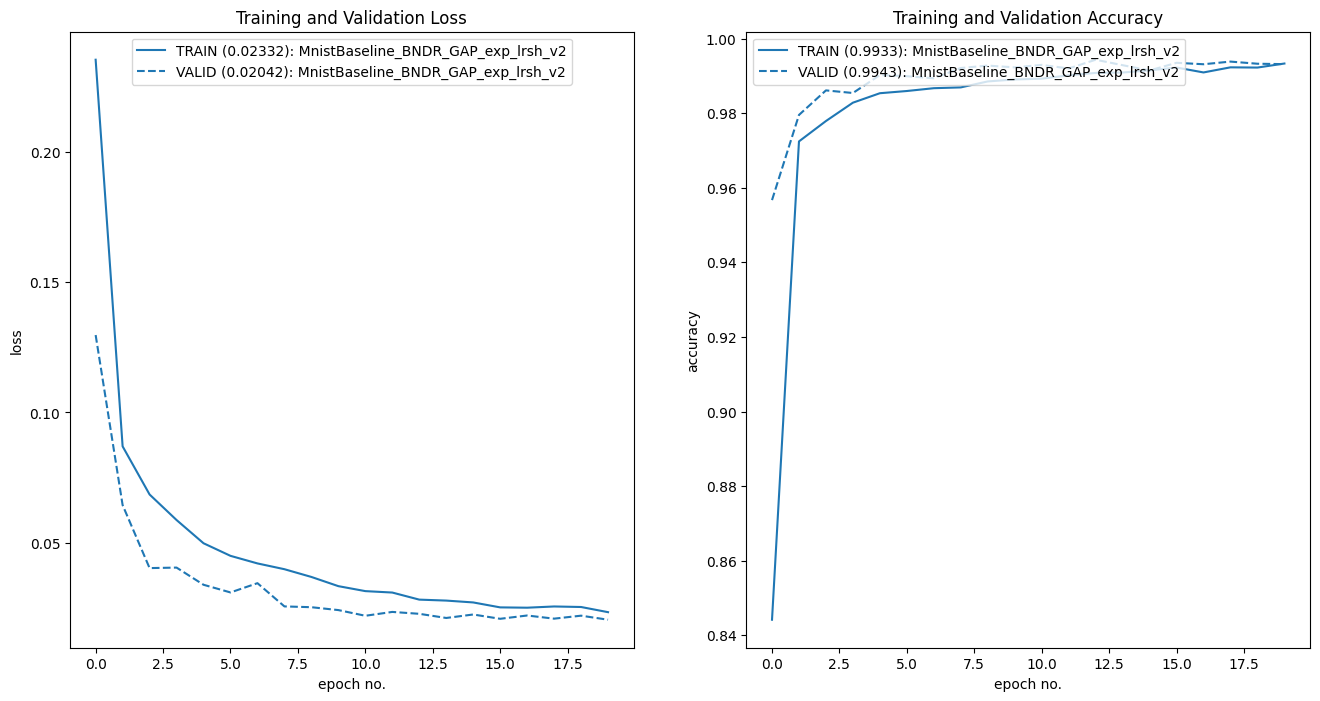

In [120]:
plot_loss_accuracy(train_loss= [train_losses],
                   val_loss= [test_losses],
                   train_acc= [train_metrics],
                   val_acc= [test_metrics],
                   labels=['MnistBaseline_BNDR_GAP_exp_lrsh_v2'],
                   colors=['blue'],
                   loss_legend_loc='upper center',
                   acc_legend_loc='upper left')

#### Cyclic LR Annealing

In [127]:
# New Model Instance
best_model1 = MnistBaseline_BNDR_GAP(in_channels=1,
                                           hidden_units=16,
                                           out_channels=10).to(device)
summary(normalized_model_gap, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             160
       BatchNorm2d-2           [-1, 16, 28, 28]              32
              ReLU-3           [-1, 16, 28, 28]               0
            Conv2d-4           [-1, 16, 28, 28]           2,320
       BatchNorm2d-5           [-1, 16, 28, 28]              32
              ReLU-6           [-1, 16, 28, 28]               0
         MaxPool2d-7           [-1, 16, 14, 14]               0
           Dropout-8           [-1, 16, 14, 14]               0
            Conv2d-9           [-1, 16, 14, 14]           2,320
      BatchNorm2d-10           [-1, 16, 14, 14]              32
             ReLU-11           [-1, 16, 14, 14]               0
           Conv2d-12           [-1, 16, 14, 14]           2,320
      BatchNorm2d-13           [-1, 16, 14, 14]              32
             ReLU-14           [-1, 16,

In [128]:
# driver setup----
# optmizer
optimizer = optim.Adam(best_model1.parameters(), lr=1e-2)
# loss
criterion = nn.CrossEntropyLoss()
# metric
metric = MulticlassAccuracy(device = device, num_classes=10)
# Early stopping
early_stopping = EarlyStopping(patience=5, verbose=True)

# LR Scheduler - OneCycleLR
lr_scheduler = OneCycleLR(optimizer,
                       max_lr = 1e-2 ,# Upper learning rate boundaries in the cycle for each parameter group
                       steps_per_epoch = len(train_loader), # The number of steps per epoch to train for.
                       epochs = epochs, # The number of epochs to train for.
                       anneal_strategy = 'cos')

In [129]:
train_losses = []
train_metrics = []
test_losses = []
test_metrics = []

for epoch in range(0,epochs):
  print(f'Epoch {epoch}')
  train_losses, train_metrics = train_module(best_model1, device, train_loader, optimizer, criterion, metric, train_losses, train_metrics)
  test_losses , test_metrics = test_module(best_model1, device, test_loader, criterion, metric, test_losses, test_metrics)
  lr_scheduler.step() # lr scheduler stepping
  print(f"For next epoch {lr_scheduler.get_last_lr()[0]}")
  early_stopping(test_losses[-1], best_model1, epoch) # last recorded test loss to measure the improvement against the prior one
  if early_stopping.early_stop:
    print("Early stopping")
    break

Epoch 0


Avg Train Loss: 0.8151899288331014 Avg Train Metric: 0.5728420774057221: 100%|██████████| 469/469 [00:39<00:00, 11.86it/s]


Function Took 39.5350 seconds


Avg Test Loss: 0.17447484803350666 Avg Test Metric: 0.953496416158314: 100%|██████████| 79/79 [00:06<00:00, 12.87it/s]


Function Took 6.1446 seconds
For next epoch 0.0004000029934463408
Validation loss decreased (inf --> 0.174475).  Saving model ...
Epoch 1


Avg Train Loss: 0.15910580316618053 Avg Train Metric: 0.952991417476109: 100%|██████████| 469/469 [00:38<00:00, 12.10it/s]


Function Took 38.7763 seconds


Avg Test Loss: 0.09074197368861377 Avg Test Metric: 0.9740421153322051: 100%|██████████| 79/79 [00:06<00:00, 12.90it/s]


Function Took 6.1292 seconds
For next epoch 0.00040001197378163045
Validation loss decreased (0.174475 --> 0.090742).  Saving model ...
Epoch 2


Avg Train Loss: 0.10726310557393885 Avg Train Metric: 0.9665258974154621: 100%|██████████| 469/469 [00:38<00:00, 12.04it/s]


Function Took 38.9528 seconds


Avg Test Loss: 0.0585325996191064 Avg Test Metric: 0.9831779221945172: 100%|██████████| 79/79 [00:06<00:00, 12.70it/s]


Function Took 6.2258 seconds
For next epoch 0.0004000269409946671
Validation loss decreased (0.090742 --> 0.058533).  Saving model ...
Epoch 3


Avg Train Loss: 0.08853550039843391 Avg Train Metric: 0.9734037193153967: 100%|██████████| 469/469 [00:38<00:00, 12.05it/s]


Function Took 38.9353 seconds


Avg Test Loss: 0.05971498224483449 Avg Test Metric: 0.9822559288785427: 100%|██████████| 79/79 [00:06<00:00, 12.97it/s]


Function Took 6.0961 seconds
For next epoch 0.0004000478950667852
EarlyStopping counter: 1 out of 5
Epoch 4


Avg Train Loss: 0.07449492222186663 Avg Train Metric: 0.9759388202543198: 100%|██████████| 469/469 [00:38<00:00, 12.12it/s]


Function Took 38.7051 seconds


Avg Test Loss: 0.04830171723107371 Avg Test Metric: 0.9870084546789338: 100%|██████████| 79/79 [00:05<00:00, 13.18it/s]


Function Took 6.0016 seconds
For next epoch 0.00040007483597184583
Validation loss decreased (0.058533 --> 0.048302).  Saving model ...
Epoch 5


Avg Train Loss: 0.06642074756888247 Avg Train Metric: 0.9792370261159787: 100%|██████████| 469/469 [00:38<00:00, 12.20it/s]


Function Took 38.4497 seconds


Avg Test Loss: 0.04288306130579661 Avg Test Metric: 0.9845568077473701: 100%|██████████| 79/79 [00:05<00:00, 13.28it/s]


Function Took 5.9522 seconds
For next epoch 0.0004001077636762492
Validation loss decreased (0.048302 --> 0.042883).  Saving model ...
Epoch 6


Avg Train Loss: 0.058625676055579806 Avg Train Metric: 0.9820995245661054: 100%|██████████| 469/469 [00:38<00:00, 12.31it/s]


Function Took 38.1183 seconds


Avg Test Loss: 0.04465980429343785 Avg Test Metric: 0.9861040432241899: 100%|██████████| 79/79 [00:05<00:00, 13.21it/s]


Function Took 5.9833 seconds
For next epoch 0.000400146678138924
EarlyStopping counter: 1 out of 5
Epoch 7


Avg Train Loss: 0.055832397133143724 Avg Train Metric: 0.9822137284634719: 100%|██████████| 469/469 [00:38<00:00, 12.15it/s]


Function Took 38.6142 seconds


Avg Test Loss: 0.03604617853990839 Avg Test Metric: 0.9896433692944201: 100%|██████████| 79/79 [00:06<00:00, 13.03it/s]


Function Took 6.0690 seconds
For next epoch 0.0004001915793113344
Validation loss decreased (0.042883 --> 0.036046).  Saving model ...
Epoch 8


Avg Train Loss: 0.054004820474763036 Avg Train Metric: 0.9837660424744905: 100%|██████████| 469/469 [00:39<00:00, 11.99it/s]


Function Took 39.1293 seconds


Avg Test Loss: 0.037013445031840966 Avg Test Metric: 0.9893192407451098: 100%|██████████| 79/79 [00:06<00:00, 12.85it/s]


Function Took 6.1543 seconds
For next epoch 0.00040024246713747484
EarlyStopping counter: 1 out of 5
Epoch 9


Avg Train Loss: 0.052784842319850096 Avg Train Metric: 0.9843904987327071: 100%|██████████| 469/469 [00:39<00:00, 12.01it/s]


Function Took 39.0704 seconds


Avg Test Loss: 0.03676303706715426 Avg Test Metric: 0.9894377732578712: 100%|██████████| 79/79 [00:06<00:00, 12.94it/s]


Function Took 6.1119 seconds
For next epoch 0.000400299341553877
EarlyStopping counter: 2 out of 5
Epoch 10


Avg Train Loss: 0.04881730176774519 Avg Train Metric: 0.9844677143259597: 100%|██████████| 469/469 [00:39<00:00, 11.76it/s]


Function Took 39.8724 seconds


Avg Test Loss: 0.033749143485439635 Avg Test Metric: 0.9878361270397524: 100%|██████████| 79/79 [00:06<00:00, 13.01it/s]


Function Took 6.0749 seconds
For next epoch 0.0004003622024896028
Validation loss decreased (0.036046 --> 0.033749).  Saving model ...
Epoch 11


Avg Train Loss: 0.04869380166133245 Avg Train Metric: 0.9857227691014607:  16%|█▌        | 75/469 [00:06<00:34, 11.50it/s]


KeyboardInterrupt: 

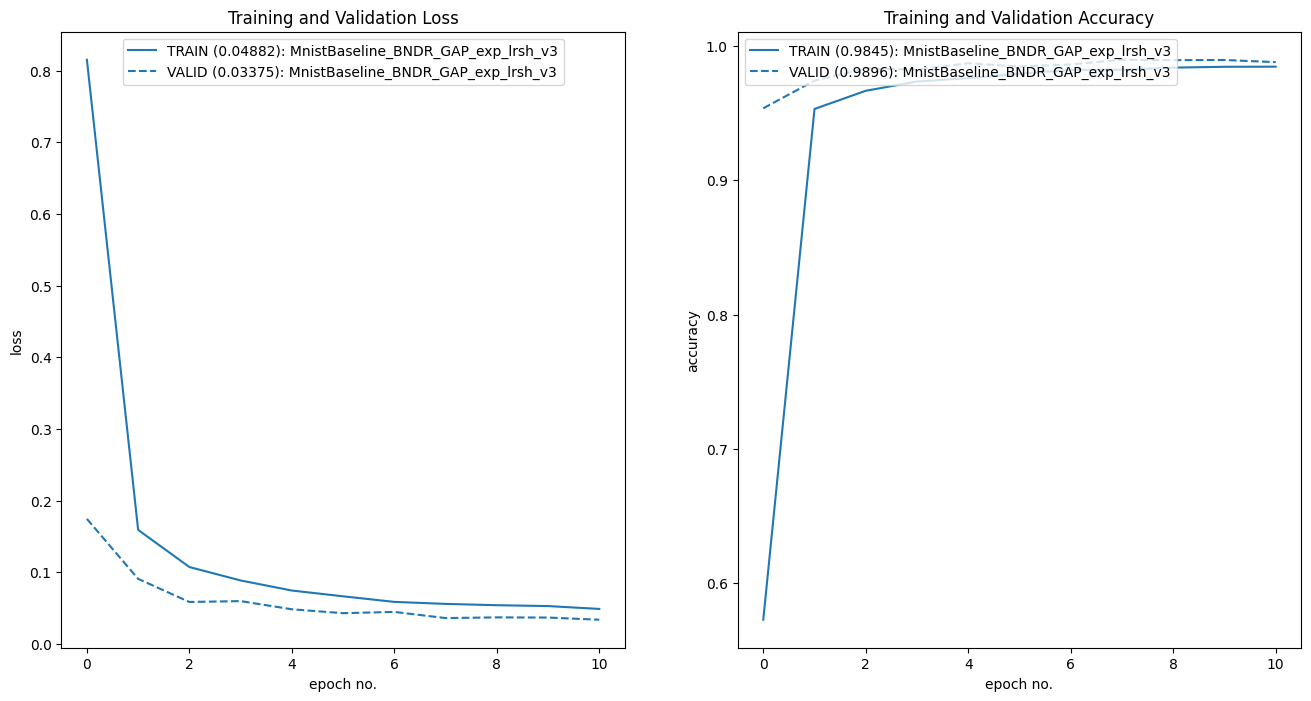

In [130]:
plot_loss_accuracy(train_loss= [train_losses],
                   val_loss= [test_losses],
                   train_acc= [train_metrics],
                   val_acc= [test_metrics],
                   labels=['MnistBaseline_BNDR_GAP_exp_lrsh_v3'],
                   colors=['blue'],
                   loss_legend_loc='upper center',
                   acc_legend_loc='upper left')

### Reduce LR on Plateau

In [140]:
# New Model Instance
best_model1 = MnistBaseline_BNDR_GAP(in_channels=1,
                                           hidden_units=16,
                                           out_channels=10).to(device)
summary(normalized_model_gap, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             160
       BatchNorm2d-2           [-1, 16, 28, 28]              32
              ReLU-3           [-1, 16, 28, 28]               0
            Conv2d-4           [-1, 16, 28, 28]           2,320
       BatchNorm2d-5           [-1, 16, 28, 28]              32
              ReLU-6           [-1, 16, 28, 28]               0
         MaxPool2d-7           [-1, 16, 14, 14]               0
           Dropout-8           [-1, 16, 14, 14]               0
            Conv2d-9           [-1, 16, 14, 14]           2,320
      BatchNorm2d-10           [-1, 16, 14, 14]              32
             ReLU-11           [-1, 16, 14, 14]               0
           Conv2d-12           [-1, 16, 14, 14]           2,320
      BatchNorm2d-13           [-1, 16, 14, 14]              32
             ReLU-14           [-1, 16,

In [142]:
# driver setup----
# optmizer
optimizer = optim.Adam(best_model1.parameters(), lr=1e-2)
# loss
criterion = nn.CrossEntropyLoss()
# metric
metric = MulticlassAccuracy(device = device, num_classes=10)
# Early stopping
early_stopping = EarlyStopping(patience=5, verbose=True)

# LR Scheduler on Val loss plateau
lr_scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=3, threshold=0.001, verbose=True)

In [143]:
train_losses = []
train_metrics = []
test_losses = []
test_metrics = []

for epoch in range(0,epochs):
  print(f'Epoch {epoch}')
  train_losses, train_metrics = train_module(best_model1, device, train_loader, optimizer, criterion, metric, train_losses, train_metrics)
  test_losses , test_metrics = test_module(best_model1, device, test_loader, criterion, metric, test_losses, test_metrics)
  lr_scheduler.step(test_metrics[-1]) # lr scheduler stepping as per val metrics in max mode
  early_stopping(test_losses[-1], best_model1, epoch) # last recorded test loss to measure the improvement against the prior one
  if early_stopping.early_stop:
    print("Early stopping")
    break

Epoch 0


Avg Train Loss: 0.2363879617645161 Avg Train Metric: 0.8451916408627781: 100%|██████████| 469/469 [00:38<00:00, 12.12it/s]


Function Took 38.7120 seconds


Avg Test Loss: 0.10480470648860629 Avg Test Metric: 0.9638150809686395: 100%|██████████| 79/79 [00:06<00:00, 12.79it/s]


Function Took 6.1843 seconds
Validation loss decreased (inf --> 0.104805).  Saving model ...
Epoch 1


Avg Train Loss: 0.09151217647429023 Avg Train Metric: 0.9695423270847752: 100%|██████████| 469/469 [00:38<00:00, 12.12it/s]


Function Took 38.6940 seconds


Avg Test Loss: 0.0837322122452757 Avg Test Metric: 0.9747018723548213: 100%|██████████| 79/79 [00:05<00:00, 13.26it/s]


Function Took 5.9648 seconds
Validation loss decreased (0.104805 --> 0.083732).  Saving model ...
Epoch 2


Avg Train Loss: 0.07721834359114677 Avg Train Metric: 0.976294036740179: 100%|██████████| 469/469 [00:38<00:00, 12.23it/s]


Function Took 38.3424 seconds


Avg Test Loss: 0.046718814759515226 Avg Test Metric: 0.9847835551334333: 100%|██████████| 79/79 [00:06<00:00, 13.12it/s]


Function Took 6.0251 seconds
Validation loss decreased (0.083732 --> 0.046719).  Saving model ...
Epoch 3


Avg Train Loss: 0.06887473639990412 Avg Train Metric: 0.9779749972733862: 100%|██████████| 469/469 [00:38<00:00, 12.24it/s]


Function Took 38.3141 seconds


Avg Test Loss: 0.049737902499641044 Avg Test Metric: 0.9847183038916769: 100%|██████████| 79/79 [00:06<00:00, 13.07it/s]


Function Took 6.0512 seconds
EarlyStopping counter: 1 out of 5
Epoch 4


Avg Train Loss: 0.06463091643149856 Avg Train Metric: 0.9797112946825495: 100%|██████████| 469/469 [00:38<00:00, 12.10it/s]


Function Took 38.7631 seconds


Avg Test Loss: 0.048438308546850106 Avg Test Metric: 0.9856065149548687: 100%|██████████| 79/79 [00:06<00:00, 13.09it/s]


Function Took 6.0441 seconds
EarlyStopping counter: 2 out of 5
Epoch 5


Avg Train Loss: 0.05934797789651289 Avg Train Metric: 0.9809251345042735: 100%|██████████| 469/469 [00:38<00:00, 12.19it/s]


Function Took 38.4752 seconds


Avg Test Loss: 0.044161875284265115 Avg Test Metric: 0.9886044625994526: 100%|██████████| 79/79 [00:06<00:00, 13.14it/s]


Function Took 6.0186 seconds
Validation loss decreased (0.046719 --> 0.044162).  Saving model ...
Epoch 6


Avg Train Loss: 0.05800452157120302 Avg Train Metric: 0.9831767635050613: 100%|██████████| 469/469 [00:38<00:00, 12.19it/s]


Function Took 38.4853 seconds


Avg Test Loss: 0.050819274421215435 Avg Test Metric: 0.9830261702778973: 100%|██████████| 79/79 [00:06<00:00, 12.95it/s]


Function Took 6.1078 seconds
EarlyStopping counter: 1 out of 5
Epoch 7


Avg Train Loss: 0.056943094777340476 Avg Train Metric: 0.9822558754288566: 100%|██████████| 469/469 [00:38<00:00, 12.20it/s]


Function Took 38.4544 seconds


Avg Test Loss: 0.03646598133049269 Avg Test Metric: 0.9891297108010401: 100%|██████████| 79/79 [00:05<00:00, 13.30it/s]


Function Took 5.9452 seconds
Validation loss decreased (0.044162 --> 0.036466).  Saving model ...
Epoch 8


Avg Train Loss: 0.05144795938444608 Avg Train Metric: 0.9831462038605452: 100%|██████████| 469/469 [00:38<00:00, 12.22it/s]


Function Took 38.3810 seconds


Avg Test Loss: 0.0490837758436469 Avg Test Metric: 0.98538918510268: 100%|██████████| 79/79 [00:06<00:00, 13.01it/s]


Function Took 6.0776 seconds
EarlyStopping counter: 1 out of 5
Epoch 9


Avg Train Loss: 0.04902686802312922 Avg Train Metric: 0.9853525395586546: 100%|██████████| 469/469 [00:38<00:00, 12.34it/s]


Function Took 38.0188 seconds


Avg Test Loss: 0.04066348767653697 Avg Test Metric: 0.9849893850616261: 100%|██████████| 79/79 [00:05<00:00, 13.25it/s]


Function Took 5.9706 seconds
EarlyStopping counter: 2 out of 5
Epoch 10


Avg Train Loss: 0.04849082869993868 Avg Train Metric: 0.986012206402923: 100%|██████████| 469/469 [00:38<00:00, 12.25it/s]


Function Took 38.2837 seconds


Avg Test Loss: 0.04493344978641577 Avg Test Metric: 0.9860238493243351: 100%|██████████| 79/79 [00:06<00:00, 12.76it/s]


Function Took 6.1969 seconds
EarlyStopping counter: 3 out of 5
Epoch 11


Avg Train Loss: 0.05992632849580225 Avg Train Metric: 0.98442723996499:   7%|▋         | 34/469 [00:02<00:37, 11.66it/s]


KeyboardInterrupt: 

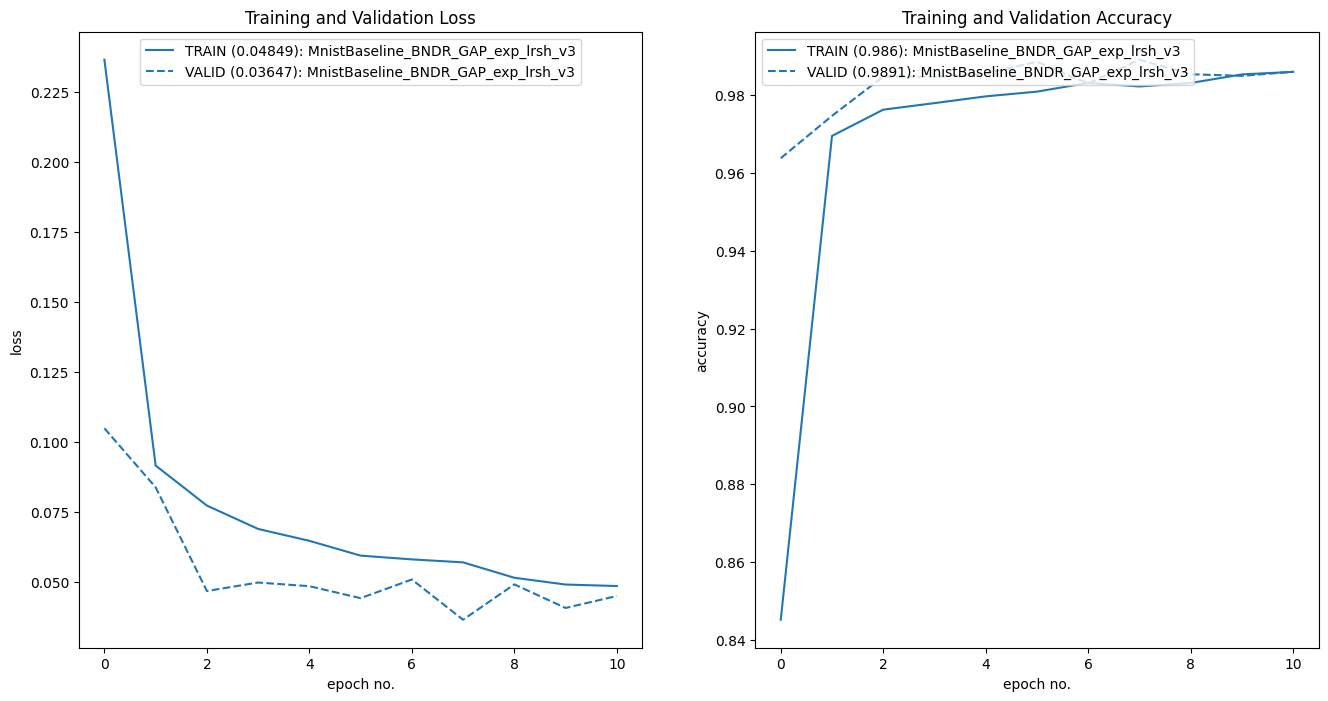

In [144]:
plot_loss_accuracy(train_loss= [train_losses],
                   val_loss= [test_losses],
                   train_acc= [train_metrics],
                   val_acc= [test_metrics],
                   labels=['MnistBaseline_BNDR_GAP_exp_lrsh_v3'],
                   colors=['blue'],
                   loss_legend_loc='upper center',
                   acc_legend_loc='upper left')

So far the best model has been MnistBaseline_BNDR_GAP with ExponentialLR with gamma value of 0.8 , we will add better weights init technique to this model

### Application of Optimal weight init techniques

In [145]:
def custom_weight_sequential(module):
  """ Custom weight initialization function for nn.Sequential layer to club multiple NN modules."""

  classname = module.__class__.__name__
  if classname.find("Conv") != -1:
      nn.init.kaiming_uniform_(tensor=module.weight, nonlinearity="relu", mode="fan_in")
      if module.bias is not None:
          nn.init.zeros_(module.bias)

  elif classname.find("BatchNorm") != -1:
      nn.init.constant_(module.weight, 1.0)
      nn.init.constant_(module.bias, 0.0)

  elif classname.find("Linear") != -1:
      nn.init.kaiming_normal_(tensor=module.weight, nonlinearity="relu", mode="fan_in")
      nn.init.zeros_(module.bias)

In [146]:
# New Model Instance
best_model1 = MnistBaseline_BNDR_GAP(in_channels=1,
                                           hidden_units=16,
                                           out_channels=10).to(device)
summary(normalized_model_gap, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             160
       BatchNorm2d-2           [-1, 16, 28, 28]              32
              ReLU-3           [-1, 16, 28, 28]               0
            Conv2d-4           [-1, 16, 28, 28]           2,320
       BatchNorm2d-5           [-1, 16, 28, 28]              32
              ReLU-6           [-1, 16, 28, 28]               0
         MaxPool2d-7           [-1, 16, 14, 14]               0
           Dropout-8           [-1, 16, 14, 14]               0
            Conv2d-9           [-1, 16, 14, 14]           2,320
      BatchNorm2d-10           [-1, 16, 14, 14]              32
             ReLU-11           [-1, 16, 14, 14]               0
           Conv2d-12           [-1, 16, 14, 14]           2,320
      BatchNorm2d-13           [-1, 16, 14, 14]              32
             ReLU-14           [-1, 16,

In [147]:
best_model1.apply(custom_weight_sequential)

MnistBaseline_BNDR_GAP(
  (block1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.1, inplace=False)
  )
  (block2): Sequential(
    (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilatio

In [149]:
# driver setup----
# optmizer
optimizer = optim.Adam(best_model1.parameters(), lr=1e-2)
# loss
criterion = nn.CrossEntropyLoss()
# metric
metric = MulticlassAccuracy(device = device, num_classes=10)
# Early stopping
early_stopping = EarlyStopping(patience=5, verbose=True)

# LR Scheduler - Exponential
lr_scheduler = ExponentialLR(optimizer,gamma = 0.8) # lr_t = lr_t-1 * gamma

In [150]:
train_losses = []
train_metrics = []
test_losses = []
test_metrics = []

for epoch in range(0,epochs):
  print(f'Epoch {epoch}')
  train_losses, train_metrics = train_module(best_model1, device, train_loader, optimizer, criterion, metric, train_losses, train_metrics)
  test_losses , test_metrics = test_module(best_model1, device, test_loader, criterion, metric, test_losses, test_metrics)
  lr_scheduler.step() # lr scheduler stepping
  print(f"For next epoch {lr_scheduler.get_last_lr()[0]}")
  early_stopping(test_losses[-1], best_model1, epoch) # last recorded test loss to measure the improvement against the prior one
  if early_stopping.early_stop:
    print("Early stopping")
    break

Epoch 0


Avg Train Loss: 0.24210937694707976 Avg Train Metric: 0.8296937916292819: 100%|██████████| 469/469 [00:39<00:00, 11.87it/s]


Function Took 39.5022 seconds


Avg Test Loss: 0.08847732799528521 Avg Test Metric: 0.9677949645851232: 100%|██████████| 79/79 [00:06<00:00, 12.64it/s]


Function Took 6.2544 seconds
For next epoch 0.008
Validation loss decreased (inf --> 0.088477).  Saving model ...
Epoch 1


Avg Train Loss: 0.08886594372763754 Avg Train Metric: 0.9709595241017942: 100%|██████████| 469/469 [00:39<00:00, 11.94it/s]


Function Took 39.2765 seconds


Avg Test Loss: 0.06544426707786662 Avg Test Metric: 0.9794318826892708: 100%|██████████| 79/79 [00:06<00:00, 12.49it/s]


Function Took 6.3281 seconds
For next epoch 0.0064
Validation loss decreased (0.088477 --> 0.065444).  Saving model ...
Epoch 2


Avg Train Loss: 0.07028499443624128 Avg Train Metric: 0.9772486966301892: 100%|██████████| 469/469 [00:39<00:00, 12.01it/s]


Function Took 39.0435 seconds


Avg Test Loss: 0.057260199838989896 Avg Test Metric: 0.9829137114029897: 100%|██████████| 79/79 [00:06<00:00, 12.78it/s]


Function Took 6.1860 seconds
For next epoch 0.00512
Validation loss decreased (0.065444 --> 0.057260).  Saving model ...
Epoch 3


Avg Train Loss: 0.06014674834247782 Avg Train Metric: 0.9810333007942639: 100%|██████████| 469/469 [00:38<00:00, 12.20it/s]


Function Took 38.4444 seconds


Avg Test Loss: 0.047874913435971625 Avg Test Metric: 0.9836469126653068: 100%|██████████| 79/79 [00:06<00:00, 13.10it/s]


Function Took 6.0388 seconds
For next epoch 0.004096000000000001
Validation loss decreased (0.057260 --> 0.047875).  Saving model ...
Epoch 4


Avg Train Loss: 0.05131048684878183 Avg Train Metric: 0.9836341370143362: 100%|██████████| 469/469 [00:38<00:00, 12.13it/s]


Function Took 38.6632 seconds


Avg Test Loss: 0.03488610607654422 Avg Test Metric: 0.9885817487028581: 100%|██████████| 79/79 [00:05<00:00, 13.24it/s]


Function Took 5.9733 seconds
For next epoch 0.0032768000000000007
Validation loss decreased (0.047875 --> 0.034886).  Saving model ...
Epoch 5


Avg Train Loss: 0.04550071605103913 Avg Train Metric: 0.9863129138692356: 100%|██████████| 469/469 [00:38<00:00, 12.18it/s]


Function Took 38.4970 seconds


Avg Test Loss: 0.03425588519212973 Avg Test Metric: 0.9891211096244522: 100%|██████████| 79/79 [00:06<00:00, 12.93it/s]


Function Took 6.1190 seconds
For next epoch 0.002621440000000001
Validation loss decreased (0.034886 --> 0.034256).  Saving model ...
Epoch 6


Avg Train Loss: 0.04126372465368376 Avg Train Metric: 0.9872854313870737: 100%|██████████| 469/469 [00:38<00:00, 12.19it/s]


Function Took 38.4950 seconds


Avg Test Loss: 0.027975855181524175 Avg Test Metric: 0.9915687607813485: 100%|██████████| 79/79 [00:05<00:00, 13.31it/s]


Function Took 5.9403 seconds
For next epoch 0.002097152000000001
Validation loss decreased (0.034256 --> 0.027976).  Saving model ...
Epoch 7


Avg Train Loss: 0.03939918993261339 Avg Train Metric: 0.9873259863111256: 100%|██████████| 469/469 [00:38<00:00, 12.25it/s]


Function Took 38.3047 seconds


Avg Test Loss: 0.02562570573815109 Avg Test Metric: 0.9916983126085016: 100%|██████████| 79/79 [00:05<00:00, 13.32it/s]


Function Took 5.9373 seconds
For next epoch 0.001677721600000001
Validation loss decreased (0.027976 --> 0.025626).  Saving model ...
Epoch 8


Avg Train Loss: 0.035608540911144064 Avg Train Metric: 0.9883748569976546: 100%|██████████| 469/469 [00:38<00:00, 12.24it/s]


Function Took 38.3247 seconds


Avg Test Loss: 0.021938698038405775 Avg Test Metric: 0.9919959563243238: 100%|██████████| 79/79 [00:06<00:00, 12.89it/s]


Function Took 6.1339 seconds
For next epoch 0.0013421772800000008
Validation loss decreased (0.025626 --> 0.021939).  Saving model ...
Epoch 9


Avg Train Loss: 0.03293701481974638 Avg Train Metric: 0.9902233102682557: 100%|██████████| 469/469 [00:38<00:00, 12.20it/s]


Function Took 38.4609 seconds


Avg Test Loss: 0.024746912804172856 Avg Test Metric: 0.9912350562554372: 100%|██████████| 79/79 [00:06<00:00, 13.07it/s]


Function Took 6.0503 seconds
For next epoch 0.0010737418240000006
EarlyStopping counter: 1 out of 5
Epoch 10


Avg Train Loss: 0.03240073991712056 Avg Train Metric: 0.9905698946289925: 100%|██████████| 469/469 [00:38<00:00, 12.16it/s]


Function Took 38.5774 seconds


Avg Test Loss: 0.02604452859539586 Avg Test Metric: 0.9913701701767837: 100%|██████████| 79/79 [00:05<00:00, 13.24it/s]


Function Took 5.9704 seconds
For next epoch 0.0008589934592000006
EarlyStopping counter: 2 out of 5
Epoch 11


Avg Train Loss: 0.030139717275151676 Avg Train Metric: 0.9902527539460644: 100%|██████████| 469/469 [00:39<00:00, 12.00it/s]


Function Took 39.0733 seconds


Avg Test Loss: 0.028109121929907204 Avg Test Metric: 0.9917389516589008: 100%|██████████| 79/79 [00:05<00:00, 13.24it/s]


Function Took 5.9741 seconds
For next epoch 0.0006871947673600005
EarlyStopping counter: 3 out of 5
Epoch 12


Avg Train Loss: 0.029592241794526228 Avg Train Metric: 0.9906830444518946: 100%|██████████| 469/469 [00:38<00:00, 12.13it/s]


Function Took 38.6621 seconds


Avg Test Loss: 0.022436834373688208 Avg Test Metric: 0.993277829659136: 100%|██████████| 79/79 [00:06<00:00, 13.03it/s]


Function Took 6.0689 seconds
For next epoch 0.0005497558138880005
EarlyStopping counter: 4 out of 5
Epoch 13


Avg Train Loss: 0.026633623124622523 Avg Train Metric: 0.9918913010086841: 100%|██████████| 469/469 [00:38<00:00, 12.27it/s]


Function Took 38.2359 seconds


Avg Test Loss: 0.02418231343278732 Avg Test Metric: 0.990736787832236: 100%|██████████| 79/79 [00:06<00:00, 12.81it/s]

Function Took 6.1712 seconds
For next epoch 0.0004398046511104004
EarlyStopping counter: 5 out of 5
Early stopping


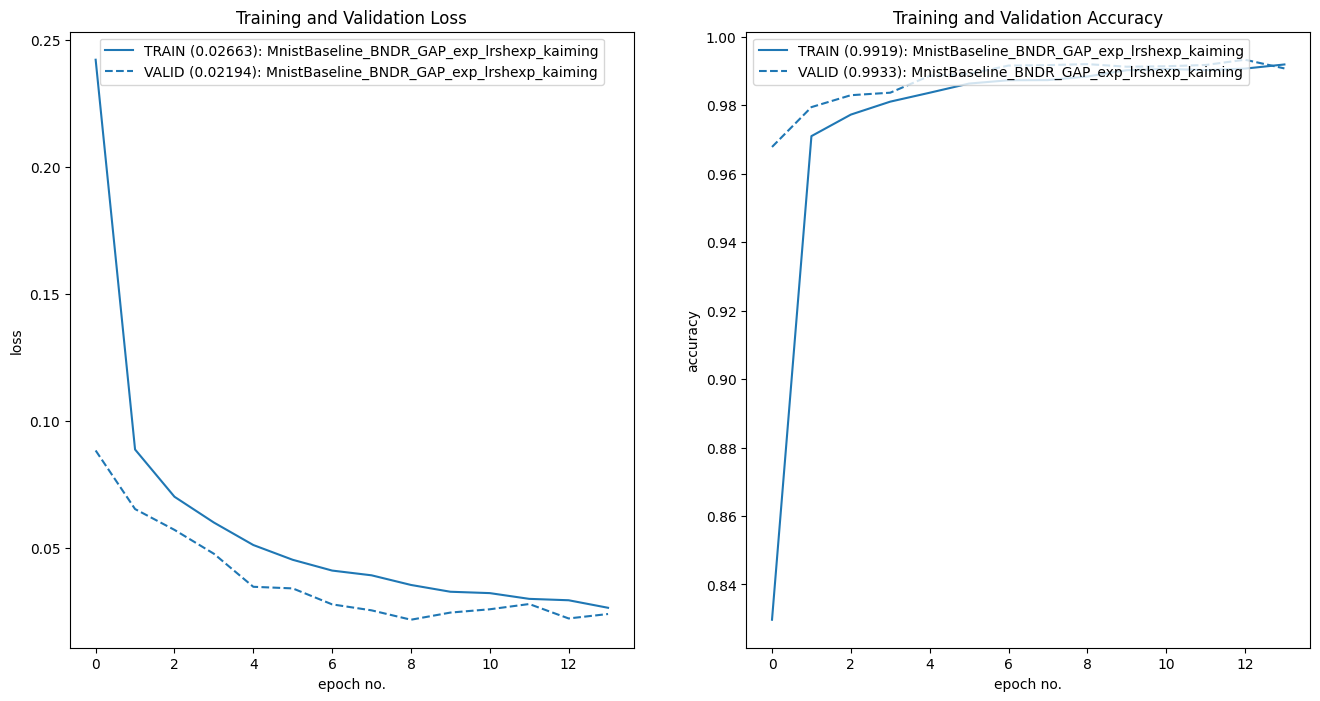

In [152]:
plot_loss_accuracy(train_loss= [train_losses],
                   val_loss= [test_losses],
                   train_acc= [train_metrics],
                   val_acc= [test_metrics],
                   labels=['MnistBaseline_BNDR_GAP_exp_lrshexp_kaiming'],
                   colors=['blue'],
                   loss_legend_loc='upper center',
                   acc_legend_loc='upper left')

## Conclusion:
The best model that has worker the best so far and has touched the mark of 99.4 is MnistBaseline_BNDR_GAP with ExponentialLR with gamma value of 0.8 with standard weight init